In [1]:
import os

# Set environment variables
os.environ['TANGOS_DB_CONNECTION'] = '/home/bk639/data/MerianSIDM/MerianSIDM.db'
os.environ['TANGOS_SIMULATION_FOLDER'] = '/home/bk639/data/MerianSIDM/'

# Imports
import tangos
import pynbody
import mytangosproperty

# Get simulations
sims = tangos.all_simulations()
print(sims)


[<Simulation("adiabatic/r431.romulus25.3072g1HsbBH")>, <Simulation("adiabatic/r431.romulus25si2s50v35")>, <Simulation("adiabatic/r468.romulus25.3072g1HsbBH")>, <Simulation("adiabatic/r468.romulus25si2s50v35")>, <Simulation("adiabatic/r488.romulus25si2s50v35")>, <Simulation("adiabatic/r492.romulus25.3072g1HsbBH")>, <Simulation("adiabatic/r492.romulus25si2s50v35")>, <Simulation("adiabatic/r523.romulus25.3072g1HsbBH")>, <Simulation("adiabatic/r523.romulus25si2s50v35")>, <Simulation("adiabatic/r544.romulus25.3072g1HsbBH")>, <Simulation("adiabatic/r544.romulus25si2s50v35")>, <Simulation("adiabatic/r597.romulus25si2s50v35")>, <Simulation("adiabatic/r618.romulus25.3072g1HsbBH")>, <Simulation("adiabatic/r618.romulus25si2s50v35")>, <Simulation("r431.romulus25.3072g1HsbBH")>, <Simulation("r468.romulus25.3072g1HsbBH")>, <Simulation("r468.romulus25si2s50v35")>, <Simulation("r488.romulus25.3072g1HsbBH")>, <Simulation("r488.romulus25si2s50v35")>, <Simulation("r492.romulus25.3072g1HsbBH")>, <Simulati

# list properties I need to make:
- shape of halo
- shape of stars
- mass of halo
- mass of stars
- half light radius
- half mass radius
- half mass radius of stars
- half mass radius of dark matter
- effective radius of stars
-

In [12]:
def smooth_shape(rbins, ba, ca):
    k = 4
    s_factor = 1
    """
    Smooth and filter data, handling a few NaN values gracefully.

    Parameters:
    rbins, ba, ca: array-like, input data
    k: int, degree of the smoothing spline (default 3)
    s_factor: float, smoothing factor as a fraction of len(rbins) (default 0.01)
    residual_threshold, jump_threshold, jump_percentage: unused in this version

    Returns:
    rbins, ba, ca: filtered arrays
    ba_s, ca_s: smoothed spline functions
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Remove rows where either ba or ca is NaN
    mask = ~np.isnan(ba) & ~np.isnan(ca)
    rbins_filtered = rbins[mask]
    ba_filtered = ba[mask]
    ca_filtered = ca[mask]

    # Calculate smoothing parameter
    s = s_factor * len(rbins_filtered)

    # Create splines
    #print(rbins_filtered, ba_filtered)
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)



    n = len(rbins_filtered)
    # calculate residuals and remove outliers
    ba_residuals = ba_filtered - ba_s(rbins_filtered)
    ca_residuals = ca_filtered - ca_s(rbins_filtered)
    # calculate the standard deviation of the residuals
    ba_std = np.std(ba_residuals)
    ca_std = np.std(ca_residuals)
    # remove outliers
    d = 3

    mask = np.abs(ba_residuals) < d * ba_std

    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    mask = np.abs(ca_residuals[mask]) < d * ca_std
    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # remove any points that are isolated in space
    # calculate the difference between each point

    diff = np.diff(rbins_filtered, prepend=0)
    # print(diff)
    # mask isolated points
    mask = diff > 1

    rbins_filtered = rbins_filtered[~mask]
    ba_filtered = ba_filtered[~mask]
    ca_filtered = ca_filtered[~mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)


    return rbins_filtered, ba_filtered, ca_filtered, ba_s, ca_s



In [12]:
sim = sims[-1]
print(sim)

<Simulation("r618.romulus25si2s50v35")>


In [13]:
#usef

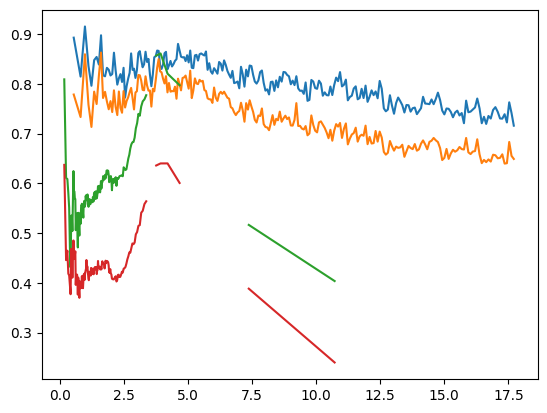

In [14]:
timestep = sim.timesteps[-1]
halo = timestep.halos[0]

import numpy as np
import matplotlib.pyplot as plt
# if halo['reff'] does not exist, calculate it
if 'reff' not in halo.keys():
    halo['reff'] = halo['Rhalo'] * 0.1

plt.plot(halo['rbins_d'], halo['ba_d'], label='ba_d')
plt.plot(halo['rbins_d'], halo['ca_d'], label='ca_d')
plt.plot(halo['rbins_s'], halo['ba_s'], label='ba_s')
plt.plot(halo['rbins_s'], halo['ca_s'], label='ca_s')
#plt.xlim(0, 2 * halo['reff'])












In [25]:

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
import pandas as pd

class GalaxyShapeAnalyzer:
    def __init__(self, simulations: List, verbose: bool = False):
        """
        Initialize the analyzer with a list of simulations.

        Args:
            simulations: List of simulation objects
            verbose: Whether to print detailed information during processing
        """
        self.verbose = verbose
        self.simulations = simulations

        # Create dictionaries to store simulation types
        self.cdm_sims = {}
        self.sidm_sims = {}
        self.adiabatic_sims = {}
        self.baryonic_sims = {}

        # Process and categorize simulations
        self._categorize_simulations()


    def _categorize_simulations(self):
        """Categorize simulations into CDM/SIDM and adiabatic/baryonic."""
        for sim in self.simulations:
            sim_name = str(sim)

            # Skip logs directory
            if 'logs' in sim_name:
                continue

            # Categorize based on simulation type
            is_adiabatic = 'adiabatic' in sim_name
            is_sidm = 'si2s50v35' in sim_name

            # Get halo number
            halo_num = sim_name.split('r')[1].split('.')[0]

            if is_adiabatic:
                self.adiabatic_sims[halo_num] = sim
            else:
                self.baryonic_sims[halo_num] = sim

            if is_sidm:
                self.sidm_sims[halo_num] = sim
            else:
                self.cdm_sims[halo_num] = sim
    def pair_simulations(self):
        """Pair simulations based on halo number."""
        pairs = []
        for sidm_num, sidm_sim in self.sidm_sims.items():
            cdm_sim = self.cdm_sims.get(sidm_num)
            if cdm_sim:
                pairs.append((sidm_sim, cdm_sim))
        return pairs
    def get_halo(self, sim):
        timesteps = sim.timesteps
        if len(timesteps) == 0:
            return None
        elif len(timesteps) == 1:
            return timesteps[0].halos[0]
        else:
            return timesteps[-1].halos[0]


    def plot_shape_comparison(self, halo_num: str, output_file: Optional[str] = None):
        """
        Create a comparison plot of shapes for CDM vs SIDM.

        Args:
            halo_num: Halo number to plot
            output_file: Optional file path to save the plot
        """

        # plot shape profiles
        #compare SIDM and CDM
        #adiabatic and baryonic
        # 4 plots
        combine_plots = True


        # SIDM vs CDM adiabatic ba_d
        # SIDM vs CDM baryonic ba_d
        # SIDM vs CDM adiabatic ca_d
        # SIDM vs CDM baryonic ca_d

        # 2 more plots for stars
        # SIDM vs CDM adiabatic ba_s
        # SIDM vs CDM baryonic ba_s

        for pair in self.pair_simulations():

            if sidm_sim in self.baryonic_sims.values():
                fig,ax = plt.subplots(2,2, figsize=(12,12))
                is_bar = True
            else:
                fig,ax = plt.subplots(1,2, figsize=(6,12))
                is_bar = False
            sidm_sim, cdm_sim = pair
            sidm_halo = self.get_halo(sidm_sim)
            cdm_halo = self.get_halo(cdm_sim)
            rbins_d_sidm, ba_d_sidm, ca_d_sidm = sidm_halo['rbins_d'], sidm_halo['ba_d'], sidm_halo['ca_d']
            #smooth the data
            rbins_d_sidm, ba_d_sidm, ca_d_sidm, ba_d_sidm_s, ca_d_sidm_s = smooth_shape(rbins_d_sidm, ba_d_sidm, ca_d_sidm)
            rbins_d_cdm, ba_d_cdm, ca_d_cdm = cdm_halo['rbins_d'], cdm_halo['ba_d'], cdm_halo['ca_d']
            #smooth the data
            rbins_d_cdm, ba_d_cdm, ca_d_cdm, ba_d_cdm_s, ca_d_cdm_s = smooth_shape(rbins_d_cdm, ba_d_cdm, ca_d_cdm)

            if is_bar:
                ax1 = ax[1,0]
                ax2 = ax[1,1]
                #make baryonic plots for SIDM and CDM
                rbins_s_sidm, ba_s_sidm, ca_s_sidm = sidm_halo['rbins_s'], sidm_halo['ba_s'], sidm_halo['ca_s']
                rbins_s_sidm, ba_s_sidm, ca_s_sidm, ba_s_sidm_s, ca_s_sidm_s = smooth_shape(rbins_s_sidm, ba_s_sidm, ca_s_sidm)
                rbins_s_cdm, ba_s_cdm, ca_s_cdm = cdm_halo['rbins_s'], cdm_halo['ba_s'], cdm_halo['ca_s']
                rbins_s_cdm, ba_s_cdm, ca_s_cdm, ba_s_cdm_s, ca_s_cdm_s = smooth_shape(rbins_s_cdm, ba_s_cdm, ca_s_cdm)
                ax1.plot(rbins_s_sidm, ba_s_sidm, label='SIDM')
                ax1.plot(rbins_s_cdm, ba_s_cdm, label='CDM')
                ax2.plot(rbins_s_sidm, ca_s_sidm, label='SIDM')
                ax2.plot(rbins_s_cdm, ca_s_cdm, label='CDM')
                ax1.set_title('Baryonic ba_d')
                ax1.set_xlabel('Radius')
                ax1.set_ylabel('ba_d')
                ax1.legend()
                ax2.set_title('Baryonic ca_d')
                ax2.set_xlabel('Radius')
                ax2.set_ylabel('ca_d')
                ax2.legend()
                ax1 = ax[0,0]
                ax2 = ax[0,1]
            if not is_bar:
                ax1 = ax[0]
                ax2 = ax[1]
            ax1.plot(rbins_d_sidm, ba_d_sidm, label='SIDM')
            ax1.plot(rbins_d_cdm, ba_d_cdm, label='CDM')
            ax2.plot(rbins_d_sidm, ca_d_sidm, label='SIDM')
            ax2.plot(rbins_d_cdm, ca_d_cdm, label='CDM')


        # plot rhalf vs ba_s and ca_s at rhalf
        fig,ax = plt.subplots(1,2, figsize=(12,6))
        for pair in self.pair_simulations:
            if sidm_sim in self.baryonic_sims.values():
                sidm_sim, cdm_sim = pair
                sidm_halo = self.get_halo(sidm_sim)
                cdm_halo = self.get_halo(cdm_sim)
                ax1 = ax[0]
                ax2 = ax[1]
                rbins_s_sidm, ba_s_sidm, ca_s_sidm = sidm_halo['rbins_s'], sidm_halo['ba_s'], sidm_halo['ca_s']
                rbins_s_cdm, ba_s_cdm, ca_s_cdm = cdm_halo['rbins_s'], cdm_halo['ba_s'], cdm_halo['ca_s']
                #smooth the data
                rbins_s_sidm, ba_s_sidm, ca_s_sidm, ba_s_sidm_s, ca_s_sidm_s = smooth_shape(rbins_s_sidm, ba_s_sidm, ca_s_sidm)
                rbins_s_cdm, ba_s_cdm, ca_s_cdm, ba_s_cdm_s, ca_s_cdm_s = smooth_shape(rbins_s_cdm, ba_s_cdm, ca_s_cdm)
                #evaluate the spline at rhalf
                rhalf_sidm = sidm_halo['rhalf']
                rhalf_cdm = cdm_halo['rhalf']
                ba_s_sidm_rhalf = ba_s_sidm_s(rhalf_sidm)
                ba_s_cdm_rhalf = ba_s_cdm_s(rhalf_cdm)
                ca_s_sidm_rhalf = ca_s_sidm_s(rhalf_sidm)
                ca_s_cdm_rhalf = ca_s_cdm_s(rhalf_cdm)
                ax1.plot(rhalf_sidm, ba_s_sidm_rhalf, 'o', label='SIDM')
                ax1.plot(rhalf_cdm, ba_s_cdm_rhalf, 'o', label='CDM')
                ax2.plot(rhalf_sidm, ca_s_sidm_rhalf, 'o', label='SIDM')
                ax2.plot(rhalf_cdm, ca_s_cdm_rhalf, 'o', label='CDM')
                ax1.set_title('ba_s at rhalf')
                ax1.set_xlabel('rhalf')
                ax1.set_ylabel('ba_s')
                ax1.legend()
                ax2.set_title('ca_s at rhalf')
                ax2.set_xlabel('rhalf')
                ax2.set_ylabel('ca_s')
                ax2.legend()
        # plot rhalf vs ba_d and ca_d at rhalf
        fig,ax = plt.subplots(1,2, figsize=(12,6))
        for pair in self.pair_simulations:
            if sidm_sim in self.baryonic_sims.values():
                sidm_sim, cdm_sim = pair
                sidm_halo = self.get_halo(sidm_sim)
                cdm_halo = self.get_halo(cdm_sim)
                ax1 = ax[0]
                ax2 = ax[1]
                rbins_d_sidm, ba_d_sidm, ca_d_sidm = sidm_halo['rbins_d'], sidm_halo['ba_d'], sidm_halo['ca_d']
                rbins_d_cdm, ba_d_cdm, ca_d_cdm = cdm_halo['rbins_d'], cdm_halo['ba_d'], cdm_halo['ca_d']
                #smooth the data
                rbins_d_sidm, ba_d_sidm, ca_d_sidm, ba_d_sidm_s, ca_d_sidm_s = smooth_shape(rbins_d_sidm, ba_d_sidm, ca_d_sidm)
                rbins_d_cdm, ba_d_cdm, ca_d_cdm, ba_d_cdm_s, ca_d_cdm_s = smooth_shape(rbins_d_cdm, ba_d_cdm, ca_d_cdm)
                #evaluate the spline at rhalf
                rhalf_sidm = sidm_halo['rhalf']
                rhalf_cdm = cdm_halo['rhalf']
                ba_d_sidm_rhalf = ba_d_sidm_s(rhalf_sidm)
                ba_d_cdm_rhalf = ba_d_cdm_s(rhalf_cdm)
                ca_d_sidm_rhalf = ca_d_sidm_s(rhalf_sidm)
                ca_d_cdm_rhalf = ca_d_cdm_s(rhalf_cdm)
                ax1.plot(rhalf_sidm, ba_d_sidm_rhalf, 'o', label='SIDM')
                ax1.plot(rhalf_cdm, ba_d_cdm_rhalf, 'o', label='CDM')
                ax2.plot(rhalf_sidm, ca_d_sidm_rhalf, 'o', label='SIDM')
                ax2.plot(rhalf_cdm, ca_d_cdm_rhalf, 'o', label='CDM')
                ax1.set_title('ba_d at rhalf')
                ax1.set_xlabel('rhalf')
                ax1.set_ylabel('ba_d')
                ax1.legend()
                ax2.set_title('ca_d at rhalf')
                ax2.set_xlabel('rhalf')
                ax2.set_ylabel('ca_d')
                ax2.legend()




















In [16]:
for sim in analyzer.simulations:
    print(sim)

NameError: name 'analyzer' is not defined

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from typing import Dict, List, Tuple, Optional, NamedTuple
from dataclasses import dataclass

@dataclass
class ShapeData:
    rbins: np.ndarray
    ba: np.ndarray
    ca: np.ndarray
    ba_spline: Optional[UnivariateSpline] = None
    ca_spline: Optional[UnivariateSpline] = None

class SimulationPair(NamedTuple):
    sidm: 'Simulation'
    cdm: 'Simulation'
    is_baryonic: bool
    halo_num: str

def smooth_shape(rbins: np.ndarray, ba: np.ndarray, ca: np.ndarray,
                k: int = 5, s_factor: float = 1) -> ShapeData:
    """
    Smooth and filter shape data using a more rigorous approach.

    Args:
        rbins: Radial bins
        ba: b/a axis ratios
        ca: c/a axis ratios
        k: Degree of smoothing spline (default 4)
        s_factor: Smoothing factor (default 1)

    Returns:
        ShapeData object containing filtered and smoothed data
    """
    # Remove NaN values
    mask = ~np.isnan(ba) & ~np.isnan(ca)
    rbins_filtered = rbins[mask]
    ba_filtered = ba[mask]
    ca_filtered = ca[mask]

    if len(rbins_filtered) < k + 1:
        return ShapeData(rbins, ba, ca)

    # Calculate smoothing parameter
    s = s_factor * len(rbins_filtered)

    # Create initial splines
    ba_spline = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_spline = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # Remove outliers based on residuals
    ba_residuals = ba_filtered - ba_spline(rbins_filtered)
    ca_residuals = ca_filtered - ca_spline(rbins_filtered)

    ba_std = np.std(ba_residuals)
    ca_std = np.std(ca_residuals)
    d = 3

    # Two-step filtering process
    mask = np.abs(ba_residuals) < d * ba_std
    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]

    mask = np.abs(ca_residuals[mask]) < d * ca_std
    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]

    # Recreate splines after outlier removal
    ba_spline = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_spline = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # Remove isolated points
    diff = np.diff(rbins_filtered, prepend=0)
    mask = diff <= 1  # Keep points that are not isolated

    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]

    # Final splines
    ba_spline = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_spline = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # Create clipped versions of the splines
    def ba_spline_clipped(x):
        return np.clip(ba_spline(x), 0, 1)

    def ca_spline_clipped(x):
        return np.clip(ca_spline(x), 0, 1)

    # Return ShapeData with clipped splines
    return ShapeData(
        rbins=rbins_filtered,
        ba=ba_filtered,
        ca=ca_filtered,
        ba_spline=ba_spline_clipped,
        ca_spline=ca_spline_clipped
    )

class GalaxyShapeAnalyzer:
    def __init__(self, simulations: List['Simulation'], verbose: bool = False):
        self.verbose = verbose
        self.simulation_pairs = self._process_simulations(simulations)

        # Add common radius bins for averaging
        self.radius_bins = np.logspace(-1, 1.3, 50)  # from 0.1 to 20 kpc
              # Styling variables
        self.FIGURE_SIZE = (20, 6)
        self.LINEWIDTH = 2
        self.FONTSIZE_TITLE = 24
        self.FONTSIZE_LABEL = 20
        self.FONTSIZE_TICK = 16
        self.FONTSIZE_LEGEND = 16
        self.ALPHA_RAW = 0.5
        self.ALPHA_VLINE = 0.5

        # Colors
        self.COLOR_SIDM_DM = 'darkred'
        self.COLOR_SIDM_STAR = 'red'
        self.COLOR_CDM_DM = 'blue'
        self.COLOR_CDM_STAR = 'cyan'

        # Labels
        self.LABEL_SIDM_DM = 'SIDM Dark Matter'
        self.LABEL_SIDM_STAR = 'SIDM Stars'
        self.LABEL_CDM_DM = 'CDM Dark Matter'
        self.LABEL_CDM_STAR = 'CDM Stars'
        self.LABEL_REFF = r'R$_{eff}$'
        self.LABEL_RHALF = r'R$_{1/2}$'
        self.LABEL_BA = 'Q = B/A'
        self.LABEL_CA = 'S = C/A'
        self.POINT_SIZE = 50

    def _process_simulations(self, simulations: List['Simulation']) -> List[SimulationPair]:
        """Process and pair simulations."""
        sidm_sims = {}
        cdm_sims = {}

        for sim in simulations:
            sim_name = str(sim)
            if 'logs' in sim_name:
                continue

            halo_num = sim_name.split('r')[1].split('.')[0]
            is_baryonic = 'adiabatic' not in sim_name
            is_sidm = 'si2s50v35' in sim_name

            # Create a tuple of (simulation, is_baryonic)
            if is_sidm:
                if halo_num not in sidm_sims:
                    sidm_sims[halo_num] = {}
                sidm_sims[halo_num][is_baryonic] = sim
            else:
                if halo_num not in cdm_sims:
                    cdm_sims[halo_num] = {}
                cdm_sims[halo_num][is_baryonic] = sim

        pairs = []
        for halo_num in sidm_sims:
            if halo_num in cdm_sims:
                # Match adiabatic to adiabatic
                if False in sidm_sims[halo_num] and False in cdm_sims[halo_num]:
                    pairs.append(SimulationPair(
                        sidm_sims[halo_num][False],
                        cdm_sims[halo_num][False],
                        False,
                        halo_num
                    ))

                # Match baryonic to baryonic
                if True in sidm_sims[halo_num] and True in cdm_sims[halo_num]:
                    pairs.append(SimulationPair(
                        sidm_sims[halo_num][True],
                        cdm_sims[halo_num][True],
                        True,
                        halo_num
                    ))

        if self.verbose:
            print(f"Found {len(pairs)} matching pairs:")
            for pair in pairs:
                print(f"Halo {pair.halo_num} - {'Baryonic' if pair.is_baryonic else 'Adiabatic'}")
                print(f"  SIDM: {pair.sidm}")
                print(f"  CDM:  {pair.cdm}\n")

        return pairs

    def get_halo_data(self, sim: 'Simulation') -> Optional[Dict]:
        """Get halo data from the last timestep."""
        timesteps = sim.timesteps
        if not timesteps:
            return None
        return timesteps[-1].halos[0]

    def plot_shapes(self, save_path: Optional[str] = None):
        """Create shape comparison plots."""
        # Create figure for shape vs radius correlation
        fig_corr, ((ax1_corr, ax2_corr), (ax3_corr, ax4_corr)) = plt.subplots(2, 2, figsize=(20, 12))
        fig_corr.suptitle(r'Shape Parameters vs Half-light Radius $(r_{1/2})$', fontsize=self.FONTSIZE_TITLE)
        for ax in [ax1_corr, ax2_corr, ax3_corr, ax4_corr]:
            ax.tick_params(axis='both', which='major', labelsize=self.FONTSIZE_TICK)
        # Set titles for correlation plots
        ax1_corr.set_ylabel('Dark Matter B/A', fontsize=self.FONTSIZE_LABEL)
        ax2_corr.set_ylabel('Dark Matter C/A', fontsize=self.FONTSIZE_LABEL)
        ax3_corr.set_ylabel('Stellar B/A', fontsize=self.FONTSIZE_LABEL)
        ax4_corr.set_ylabel('Stellar C/A', fontsize=self.FONTSIZE_LABEL)

        # Plot individual shape profiles and collect correlation data
        for pair in self.simulation_pairs:
            self._plot_dark_matter_shapes(pair)
            if pair.is_baryonic:
                self._plot_stellar_shapes(pair)
                self._plot_shape_radius_correlation(pair, fig_corr,
                                                 (ax1_corr, ax2_corr), # DM axes
                                                 (ax3_corr, ax4_corr)) # Stellar axes

        # Set common properties for correlation plots
        for ax in [ax1_corr, ax2_corr, ax3_corr, ax4_corr]:
            ax.set_xlabel(r'$r_{1/2}$ (kpc)', fontsize=self.FONTSIZE_LABEL)
            #ax.set_ylabel('Axis Ratio')
            ax.set_ylim(0, 1)
            #ax.legend()
            ax.grid(True, alpha=0.2)

        plt.tight_layout()

        if save_path:
            fig_corr.savefig(f"{save_path}_correlations.pdf")

    def _plot_dark_matter_shapes(self, pair: SimulationPair):
        """Plot dark matter shape profiles with raw data points."""
        sidm_halo = self.get_halo_data(pair.sidm)
        cdm_halo = self.get_halo_data(pair.cdm)

        if not (sidm_halo and cdm_halo):
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=self.FIGURE_SIZE)

        # Process SIDM data
        sidm_shape = smooth_shape(
            sidm_halo['rbins_d'],
            sidm_halo['ba_d'],
            sidm_halo['ca_d']
        )

        # Process CDM data
        cdm_shape = smooth_shape(
            cdm_halo['rbins_d'],
            cdm_halo['ba_d'],
            cdm_halo['ca_d']
        )


        
        # Plot smoothed lines with kwargs
        sidm_bins = np.linspace(min(sidm_shape.rbins), max(sidm_shape.rbins), 100)
        cdm_bins = np.linspace(min(cdm_shape.rbins), max(cdm_shape.rbins), 100)
        
        sidm_kwargs = {'color': self.COLOR_SIDM_DM, 'lw': self.LINEWIDTH}
        cdm_kwargs = {'color': self.COLOR_CDM_DM, 'lw': self.LINEWIDTH}

        ax1.plot(sidm_bins, sidm_shape.ba_spline(sidm_bins), label = self.LABEL_SIDM_DM, **sidm_kwargs)
        ax1.plot(cdm_bins, cdm_shape.ba_spline(cdm_bins), label = self.LABEL_CDM_DM, **cdm_kwargs)
    


        
        # Plot smoothed C/A lines
        ax2.plot(sidm_bins, sidm_shape.ca_spline(sidm_bins), **sidm_kwargs)
        ax2.plot(cdm_bins, cdm_shape.ca_spline(cdm_bins), **cdm_kwargs)

        # Plot raw data points
        ax1.scatter(sidm_shape.rbins, sidm_shape.ba, 
                   color=self.COLOR_SIDM_DM, alpha=self.ALPHA_RAW, s=20, label=self.LABEL_SIDM_DM + ' (Raw)')
        ax1.scatter(cdm_shape.rbins, cdm_shape.ba, 
                   color=self.COLOR_CDM_DM, alpha=self.ALPHA_RAW, s=20, label=self.LABEL_CDM_DM + ' (Raw)')
        # Plot raw C/A data points
        ax2.scatter(sidm_shape.rbins, sidm_shape.ca, 
                   color=self.COLOR_SIDM_DM, alpha=self.ALPHA_RAW, s=20)
        ax2.scatter(cdm_shape.rbins, cdm_shape.ca, 
                   color=self.COLOR_CDM_DM, alpha=self.ALPHA_RAW, s=20)

        
        if pair.is_baryonic:
            ax1.axvline(sidm_halo['rhalf'], color=self.COLOR_SIDM_STAR, linestyle='--', alpha=self.ALPHA_VLINE, label= 'SIDM'+self.LABEL_RHALF)
            ax1.axvline(cdm_halo['rhalf'], color=self.COLOR_CDM_STAR, linestyle='--', alpha=self.ALPHA_VLINE, label= 'CDM'+self.LABEL_RHALF)
            


        # Set labels and styling
        ax1.legend(fontsize=self.FONTSIZE_LEGEND)
        ax1.set_xlabel('Radius (kpc)', fontsize=self.FONTSIZE_LABEL)
        ax1.set_ylabel(self.LABEL_BA, fontsize=self.FONTSIZE_LABEL)
        ax2.set_xlabel('Radius (kpc)', fontsize=self.FONTSIZE_LABEL)
        ax2.set_ylabel(self.LABEL_CA, fontsize=self.FONTSIZE_LABEL)
        # tick label size
        ax1.tick_params(axis='both', which='major', labelsize=self.FONTSIZE_TICK)
        ax2.tick_params(axis='both', which='major', labelsize=self.FONTSIZE_TICK)
                        

        ax1.set_ylim(0,1)
        ax2.set_ylim(0,1)

        if 'reff' in sidm_halo.keys():
            ax1.set_xlim(0, 3 * sidm_halo['reff'])
            ax2.set_xlim(0, 3 * sidm_halo['reff'])
        else:
            ax1.set_xlim(0, .2 * sidm_halo['Rhalo'])
            ax2.set_xlim(0, .2 * sidm_halo['Rhalo'])

        plt.suptitle(f'Dark Matter Shape Profiles - Sim {pair.halo_num} {"(Baryonic)" if pair.is_baryonic else "(Adiabatic)"}', 
                    fontsize=self.FONTSIZE_TITLE)
        plt.tight_layout()

    def _plot_stellar_shapes(self, pair: SimulationPair):
        """Plot stellar shape profiles for baryonic runs with raw data points."""
        sidm_halo = self.get_halo_data(pair.sidm)
        cdm_halo = self.get_halo_data(pair.cdm)

        if not (sidm_halo and cdm_halo):
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=self.FIGURE_SIZE)

        # Process stellar shape data
        sidm_shape = smooth_shape(
            sidm_halo['rbins_s'],
            sidm_halo['ba_s'],
            sidm_halo['ca_s']
        )

        cdm_shape = smooth_shape(
            cdm_halo['rbins_s'],
            cdm_halo['ba_s'],
            cdm_halo['ca_s']
        )



        # Plot smoothed lines
        sidm_bins = np.linspace(min(sidm_shape.rbins), max(sidm_shape.rbins), 100)
        cdm_bins = np.linspace(min(cdm_shape.rbins), max(cdm_shape.rbins), 100)
        
        sidm_kwargs = {'color': self.COLOR_SIDM_STAR, 'lw': self.LINEWIDTH}
        cdm_kwargs = {'color': self.COLOR_CDM_STAR, 'lw': self.LINEWIDTH}
        
        ax1.plot(sidm_bins, sidm_shape.ba_spline(sidm_bins), label = self.LABEL_SIDM_STAR, **sidm_kwargs)
        ax1.plot(cdm_bins, cdm_shape.ba_spline(cdm_bins), label = self.LABEL_CDM_STAR, **cdm_kwargs)



        # Plot smoothed C/A lines
        ax2.plot(sidm_bins, sidm_shape.ca_spline(sidm_bins), **sidm_kwargs)
        ax2.plot(cdm_bins, cdm_shape.ca_spline(cdm_bins), **cdm_kwargs)
        
                # Plot raw B/A data points
        ax1.scatter(sidm_shape.rbins, sidm_shape.ba, 
                   color=self.COLOR_SIDM_STAR, alpha=self.ALPHA_RAW, s=20, label=self.LABEL_SIDM_STAR + ' (Raw)')
        ax1.scatter(cdm_shape.rbins, cdm_shape.ba, 
                   color=self.COLOR_CDM_STAR, alpha=self.ALPHA_RAW, s=20, label=self.LABEL_CDM_STAR + ' (Raw)')
        
                # Plot raw C/A data points
        ax2.scatter(sidm_shape.rbins, sidm_shape.ca, 
                   color=self.COLOR_SIDM_STAR, alpha=self.ALPHA_RAW, s=20)
        ax2.scatter(cdm_shape.rbins, cdm_shape.ca, 
                   color=self.COLOR_CDM_STAR, alpha=self.ALPHA_RAW, s=20)

        # Plot half-light radius line
        ax1.axvline(sidm_halo['rhalf'], color=self.COLOR_SIDM_STAR, linestyle='--', alpha=self.ALPHA_VLINE, label= 'SIDM'+self.LABEL_RHALF)
        ax1.axvline(cdm_halo['rhalf'], color=self.COLOR_CDM_STAR, linestyle='--', alpha=self.ALPHA_VLINE, label= 'CDM'+self.LABEL_RHALF)
        
        # Set labels and styling
        ax1.legend(fontsize=self.FONTSIZE_LEGEND)
        ax1.set_xlabel('Radius (kpc)', fontsize=self.FONTSIZE_LABEL)
        ax1.set_ylabel(self.LABEL_BA, fontsize=self.FONTSIZE_LABEL)
        ax2.set_xlabel('Radius (kpc)', fontsize=self.FONTSIZE_LABEL)
        ax2.set_ylabel(self.LABEL_CA, fontsize=self.FONTSIZE_LABEL)
        ax1.tick_params(axis='both', which='major', labelsize=self.FONTSIZE_TICK)
        ax2.tick_params(axis='both', which='major', labelsize=self.FONTSIZE_TICK)
        

        ax1.set_ylim(0,1)
        ax2.set_ylim(0,1)

        ax1.set_xlim(0, 3 * sidm_halo['reff'])
        ax2.set_xlim(0, 3 * sidm_halo['reff'])

        plt.suptitle(f'Stellar Shape Profiles - Sim {pair.halo_num}', 
                    fontsize=self.FONTSIZE_TITLE)
        plt.tight_layout()



    def _plot_shape_radius_correlation(self, pair: SimulationPair, fig, dm_axes, stellar_axes):
        """Plot shape parameters versus half-light radius for both DM and stars."""
        if not pair.is_baryonic:
            return

        ax1_dm, ax2_dm = dm_axes
        ax1_s, ax2_s = stellar_axes

        sidm_halo = self.get_halo_data(pair.sidm)
        cdm_halo = self.get_halo_data(pair.cdm)

        if not (sidm_halo and cdm_halo):
            return

        # Get radii
        sidm_rhalf = sidm_halo['rhalf']
        cdm_rhalf = cdm_halo['rhalf']

        # Plot dark matter shapes
        for halo,label,color in [(sidm_halo, 'SIDM', self.COLOR_SIDM_DM), (cdm_halo, 'CDM', self.COLOR_CDM_DM)]:
            rhalf = halo['rhalf']

            # Dark matter shapes
            shape_data_dm = smooth_shape(
                halo['rbins_d'],
                halo['ba_d'],
                halo['ca_d']
            )

            if shape_data_dm.ba_spline and shape_data_dm.ca_spline:
                ba_rhalf_dm = shape_data_dm.ba_spline(rhalf)
                ca_rhalf_dm = shape_data_dm.ca_spline(rhalf)

                ax1_dm.scatter(rhalf, ba_rhalf_dm, color=color,s= self.POINT_SIZE)
                ax2_dm.scatter(rhalf, ca_rhalf_dm, color=color,s = self.POINT_SIZE)

        for halo,label,color in [(sidm_halo, 'SIDM', self.COLOR_SIDM_STAR), (cdm_halo, 'CDM', self.COLOR_CDM_STAR)]:
            # Stellar shapes
            rhalf = halo['rhalf']
            
            shape_data_s = smooth_shape(
                halo['rbins_s'],
                halo['ba_s'],
                halo['ca_s']
            )

            if shape_data_s.ba_spline and shape_data_s.ca_spline:
                ba_rhalf_s = shape_data_s.ba_spline(rhalf)
                ca_rhalf_s = shape_data_s.ca_spline(rhalf)

                ax1_s.scatter(rhalf, ba_rhalf_s, color=color,s = self.POINT_SIZE)
                ax2_s.scatter(rhalf, ca_rhalf_s, color=color,s= self.POINT_SIZE)

        # Link DM points
        sidm_shape_dm = smooth_shape(sidm_halo['rbins_d'], sidm_halo['ba_d'], sidm_halo['ca_d'])
        cdm_shape_dm = smooth_shape(cdm_halo['rbins_d'], cdm_halo['ba_d'], cdm_halo['ca_d'])

        if sidm_shape_dm.ba_spline and cdm_shape_dm.ba_spline:
            sidm_ba_rhalf_dm = sidm_shape_dm.ba_spline(sidm_rhalf)
            cdm_ba_rhalf_dm = cdm_shape_dm.ba_spline(cdm_rhalf)
            sidm_ca_rhalf_dm = sidm_shape_dm.ca_spline(sidm_rhalf)
            cdm_ca_rhalf_dm = cdm_shape_dm.ca_spline(cdm_rhalf)

            ax1_dm.plot([sidm_rhalf, cdm_rhalf], [sidm_ba_rhalf_dm, cdm_ba_rhalf_dm], 'k--')
            ax2_dm.plot([sidm_rhalf, cdm_rhalf], [sidm_ca_rhalf_dm, cdm_ca_rhalf_dm], 'k--')

        # Link stellar points
        sidm_shape_s = smooth_shape(sidm_halo['rbins_s'], sidm_halo['ba_s'], sidm_halo['ca_s'])
        cdm_shape_s = smooth_shape(cdm_halo['rbins_s'], cdm_halo['ba_s'], cdm_halo['ca_s'])

        if sidm_shape_s.ba_spline and cdm_shape_s.ba_spline:
            sidm_ba_rhalf_s = sidm_shape_s.ba_spline(sidm_rhalf)
            cdm_ba_rhalf_s = cdm_shape_s.ba_spline(cdm_rhalf)
            sidm_ca_rhalf_s = sidm_shape_s.ca_spline(sidm_rhalf)
            cdm_ca_rhalf_s = cdm_shape_s.ca_spline(cdm_rhalf)

            ax1_s.plot([sidm_rhalf, cdm_rhalf], [sidm_ba_rhalf_s, cdm_ba_rhalf_s], 'k--')
            ax2_s.plot([sidm_rhalf, cdm_rhalf], [sidm_ca_rhalf_s, cdm_ca_rhalf_s], 'k--')
        #create legend
        ax1_dm.legend(['SIDM','CDM'], fontsize=self.FONTSIZE_LEGEND)
        ax1_s.legend(['SIDM','CDM'], fontsize=self.FONTSIZE_LEGEND)




    def _interpolate_shape_profile(self, shape_data: ShapeData) -> Tuple[np.ndarray, np.ndarray]:
        """
        Interpolate shape profiles onto common radius bins.
        Returns ba and ca arrays interpolated onto self.radius_bins.
        """
        if shape_data.ba_spline is None or shape_data.ca_spline is None:
            return np.full_like(self.radius_bins, np.nan), np.full_like(self.radius_bins, np.nan)

        # Limit interpolation to the range of available data
        mask = (self.radius_bins >= np.min(shape_data.rbins)) & (self.radius_bins <= np.max(shape_data.rbins))
        ba_interp = np.full_like(self.radius_bins, np.nan)
        ca_interp = np.full_like(self.radius_bins, np.nan)

        ba_interp[mask] = shape_data.ba_spline(self.radius_bins[mask])
        ca_interp[mask] = shape_data.ca_spline(self.radius_bins[mask])

        return ba_interp, ca_interp

    def plot_average_shapes(self, save_path: Optional[str] = None):
        """Plot average shape profiles for all simulations, separated by type."""
        # Initialize lists to store splines and their valid ranges
        sidm_dm_splines_baryonic = []
        cdm_dm_splines_baryonic = []
        sidm_dm_splines_adiabatic = []
        cdm_dm_splines_adiabatic = []
        sidm_stellar_splines = []
        cdm_stellar_splines = []

        # Collect splines and their ranges for all halos
        for pair in self.simulation_pairs:
            sidm_halo = self.get_halo_data(pair.sidm)
            cdm_halo = self.get_halo_data(pair.cdm)

            if not (sidm_halo and cdm_halo):
                continue

            # Process dark matter shapes
            sidm_dm = smooth_shape(
                sidm_halo['rbins_d'],
                sidm_halo['ba_d'],
                sidm_halo['ca_d']
            )
            cdm_dm = smooth_shape(
                cdm_halo['rbins_d'],
                cdm_halo['ba_d'],
                cdm_halo['ca_d']
            )

            if pair.is_baryonic:
                if sidm_dm.ba_spline and sidm_dm.ca_spline:
                    r_range = (min(sidm_dm.rbins), max(sidm_dm.rbins))
                    sidm_dm_splines_baryonic.append((sidm_dm.ba_spline, sidm_dm.ca_spline, r_range))
                if cdm_dm.ba_spline and cdm_dm.ca_spline:
                    r_range = (min(cdm_dm.rbins), max(cdm_dm.rbins))
                    cdm_dm_splines_baryonic.append((cdm_dm.ba_spline, cdm_dm.ca_spline, r_range))

                # Process stellar shapes
                sidm_stellar = smooth_shape(
                    sidm_halo['rbins_s'],
                    sidm_halo['ba_s'],
                    sidm_halo['ca_s']
                )
                cdm_stellar = smooth_shape(
                    cdm_halo['rbins_s'],
                    cdm_halo['ba_s'],
                    cdm_halo['ca_s']
                )

                if sidm_stellar.ba_spline and sidm_stellar.ca_spline:
                    r_range = (min(sidm_stellar.rbins), max(sidm_stellar.rbins))
                    sidm_stellar_splines.append((sidm_stellar.ba_spline, sidm_stellar.ca_spline, r_range))
                if cdm_stellar.ba_spline and cdm_stellar.ca_spline:
                    r_range = (min(cdm_stellar.rbins), max(cdm_stellar.rbins))
                    cdm_stellar_splines.append((cdm_stellar.ba_spline, cdm_stellar.ca_spline, r_range))
            else:
                if sidm_dm.ba_spline and sidm_dm.ca_spline:
                    r_range = (min(sidm_dm.rbins), max(sidm_dm.rbins))
                    sidm_dm_splines_adiabatic.append((sidm_dm.ba_spline, sidm_dm.ca_spline, r_range))
                if cdm_dm.ba_spline and cdm_dm.ca_spline:
                    r_range = (min(cdm_dm.rbins), max(cdm_dm.rbins))
                    cdm_dm_splines_adiabatic.append((cdm_dm.ba_spline, cdm_dm.ca_spline, r_range))

        def get_valid_range(splines_with_ranges):
            """Get the overlapping valid range for a set of splines."""
            if not splines_with_ranges:
                return None, None
            r_min = max(r_range[0] for _, _, r_range in splines_with_ranges)
            r_max = min(r_range[1] for _, _, r_range in splines_with_ranges)
            return r_min, r_max

        def evaluate_splines_in_range(splines_with_ranges, r):
            """Evaluate splines only within their valid ranges."""
            ba_vals = []
            ca_vals = []
            for ba_spline, ca_spline, (r_min, r_max) in splines_with_ranges:
                # Only evaluate points within this spline's range
                mask = (r >= r_min) & (r <= r_max)
                ba_val = np.full_like(r, np.nan)
                ca_val = np.full_like(r, np.nan)
                ba_val[mask] = ba_spline(r[mask])
                ca_val[mask] = ca_spline(r[mask])
                ba_vals.append(ba_val)
                ca_vals.append(ca_val)
            return np.array(ba_vals), np.array(ca_vals)

        def plot_averages(ax1, ax2, r_eval, splines1, splines2, title,styles):
            """Plot averages for two sets of splines."""
            sidm_kwargs = {'color': styles['SIDM_color'], 'lw': self.LINEWIDTH, 'ls': styles['lines']}
            cdm_kwargs = {'color': styles['CDM_color'], 'lw': self.LINEWIDTH, 'ls': styles['lines']}
            if not (splines1 and splines2):
                return

            # Get valid ranges
            r_min1, r_max1 = get_valid_range(splines1)
            r_min2, r_max2 = get_valid_range(splines2)

            # Use the overlapping range
            r_min = max(r_min1, r_min2)
            r_max = min(r_max1, r_max2)

            # Create radius array for this range
            r = r_eval[np.where((r_eval >= r_min) & (r_eval <= r_max))]

            # Evaluate splines
            sidm_ba, sidm_ca = evaluate_splines_in_range(splines1, r)
            cdm_ba, cdm_ca = evaluate_splines_in_range(splines2, r)

            # Calculate statistics
            sidm_ba_mean = np.nanmean(sidm_ba, axis=0)
            sidm_ca_mean = np.nanmean(sidm_ca, axis=0)
            cdm_ba_mean = np.nanmean(cdm_ba, axis=0)
            cdm_ca_mean = np.nanmean(cdm_ca, axis=0)

            sidm_ba_std = np.nanstd(sidm_ba, axis=0)
            sidm_ca_std = np.nanstd(sidm_ca, axis=0)
            cdm_ba_std = np.nanstd(cdm_ba, axis=0)
            cdm_ca_std = np.nanstd(cdm_ca, axis=0)

            # Plot
            ax1.plot(r, sidm_ba_mean, label=f'SIDM (N={len(splines1)})', **sidm_kwargs)
            ax1.fill_between(r, sidm_ba_mean-sidm_ba_std, sidm_ba_mean+sidm_ba_std, alpha=0.2, color=styles['SIDM_color'])
            ax1.plot(r, cdm_ba_mean, label=f'CDM (N={len(splines2)})', **cdm_kwargs)
            ax1.fill_between(r, cdm_ba_mean-cdm_ba_std, cdm_ba_mean+cdm_ba_std, alpha=0.2, color=styles['CDM_color'])

            ax2.plot(r, sidm_ca_mean, **sidm_kwargs)
            ax2.fill_between(r, sidm_ca_mean-sidm_ca_std, sidm_ca_mean+sidm_ca_std, alpha=0.2, color=styles['SIDM_color'])
            ax2.plot(r, cdm_ca_mean, **cdm_kwargs)
            ax2.fill_between(r, cdm_ca_mean-cdm_ca_std, cdm_ca_mean+cdm_ca_std, alpha=0.2, color=styles['CDM_color'])
            
            

            # Configure axes
            for ax in [ax1, ax2]:
                ax.set_xlabel('Radius (kpc)')
                ax.set_ylim(0, 1)
                ax.legend()
                ax.grid(True, alpha=0.2)
            ax1.set_ylabel(self.LABEL_BA, fontsize=self.FONTSIZE_LABEL)
            ax2.set_ylabel(self.LABEL_CA, fontsize=self.FONTSIZE_LABEL)
            plt.suptitle(title, fontsize=self.FONTSIZE_TITLE)

        # Common radius array for evaluation (more points than before for smoother curves)
        r_eval = np.linspace(0, 20, 200)

        # Plot dark matter shapes - Baryonic
        if sidm_dm_splines_baryonic:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=self.FIGURE_SIZE)
            styles = {'SIDM_color': self.COLOR_SIDM_DM, 'CDM_color': self.COLOR_CDM_DM,'lines': '-'}
            plot_averages(ax1, ax2, r_eval,
                         sidm_dm_splines_baryonic,
                         cdm_dm_splines_baryonic,
                         'Average Dark Matter Shape Profiles (Baryonic Runs)',
                         styles)
            if save_path:
                plt.savefig(f"{save_path}_dm_baryonic.pdf")

        # Plot dark matter shapes - Adiabatic
        if sidm_dm_splines_adiabatic:
            styles = {'SIDM_color': self.COLOR_SIDM_DM, 'CDM_color': self.COLOR_CDM_DM,'lines': ':'}
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=self.FIGURE_SIZE)
            plot_averages(ax1, ax2, r_eval,
                         sidm_dm_splines_adiabatic,
                         cdm_dm_splines_adiabatic,
                         'Average Dark Matter Shape Profiles (Adiabatic Runs)',
                         styles)
            if save_path:
                plt.savefig(f"{save_path}_dm_adiabatic.pdf")

        # Plot stellar shapes
        if sidm_stellar_splines:
            styles = {'SIDM_color': self.COLOR_SIDM_STAR, 'CDM_color': self.COLOR_CDM_STAR,'lines': '-'}
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=self.FIGURE_SIZE)
            plot_averages(ax1, ax2, r_eval,
                         sidm_stellar_splines,
                         cdm_stellar_splines,
                         'Average Stellar Shape Profiles (Baryonic Runs)',
                         styles)
            if save_path:
                plt.savefig(f"{save_path}_stellar.pdf")

    # def _plot_average_with_spread(self, ax, x, y1_data, label1, color1,
    #                             y2_data, label2, color2):
    #     """
    #     Plot average line with shaded error region.
    #     """
    #     # Calculate statistics for first dataset
    #     mean1 = np.nanmean(y1_data, axis=0)
    #     std1 = np.nanstd(y1_data, axis=0)
    #
    #     # Calculate statistics for second dataset
    #     mean2 = np.nanmean(y2_data, axis=0)
    #     std2 = np.nanstd(y2_data, axis=0)
    #
    #     # Plot means
    #     ax.plot(x, mean1, '-', color=color1, label=f'{label1} (N={len(y1_data)})')
    #     ax.plot(x, mean2, '--', color=color2, label=f'{label2} (N={len(y2_data)})')
    #
    #     # Plot error regions
    #     ax.fill_between(x, mean1-std1, mean1+std1, color=color1, alpha=0.2)
    #     ax.fill_between(x, mean2-std2, mean2+std2, color=color2, alpha=0.2)
    #
    #             #limit y axis to 0-1
    #     ax.set_ylim(0,1)
    #
    #     ax.legend()
    #     ax.grid(True, which='both', alpha=0.2)
    #
    #     # Set reasonable y-limits
    #     ax.set_ylim(0, 1.1)


Found 13 matching pairs:
Halo 431 - Adiabatic
  SIDM: <Simulation("adiabatic/r431.romulus25si2s50v35")>
  CDM:  <Simulation("adiabatic/r431.romulus25.3072g1HsbBH")>

Halo 468 - Adiabatic
  SIDM: <Simulation("adiabatic/r468.romulus25si2s50v35")>
  CDM:  <Simulation("adiabatic/r468.romulus25.3072g1HsbBH")>

Halo 468 - Baryonic
  SIDM: <Simulation("r468.romulus25si2s50v35")>
  CDM:  <Simulation("r468.romulus25.3072g1HsbBH")>

Halo 488 - Baryonic
  SIDM: <Simulation("r488.romulus25si2s50v35")>
  CDM:  <Simulation("r488.romulus25.3072g1HsbBH")>

Halo 492 - Adiabatic
  SIDM: <Simulation("adiabatic/r492.romulus25si2s50v35")>
  CDM:  <Simulation("adiabatic/r492.romulus25.3072g1HsbBH")>

Halo 492 - Baryonic
  SIDM: <Simulation("r492.romulus25si2s50v35")>
  CDM:  <Simulation("r492.romulus25.3072g1HsbBH")>

Halo 523 - Adiabatic
  SIDM: <Simulation("adiabatic/r523.romulus25si2s50v35")>
  CDM:  <Simulation("adiabatic/r523.romulus25.3072g1HsbBH")>

Halo 523 - Baryonic
  SIDM: <Simulation("r523.romul

/tmp/ipykernel_3175740/2183492608.py:327: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=self.FIGURE_SIZE)
/tmp/ipykernel_3175740/2183492608.py:638: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_3175740/2183492608.py:638: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_3175740/2183492608.py:638: UserWarning: No artists with labels found to put in legend.  Note that artists whose l

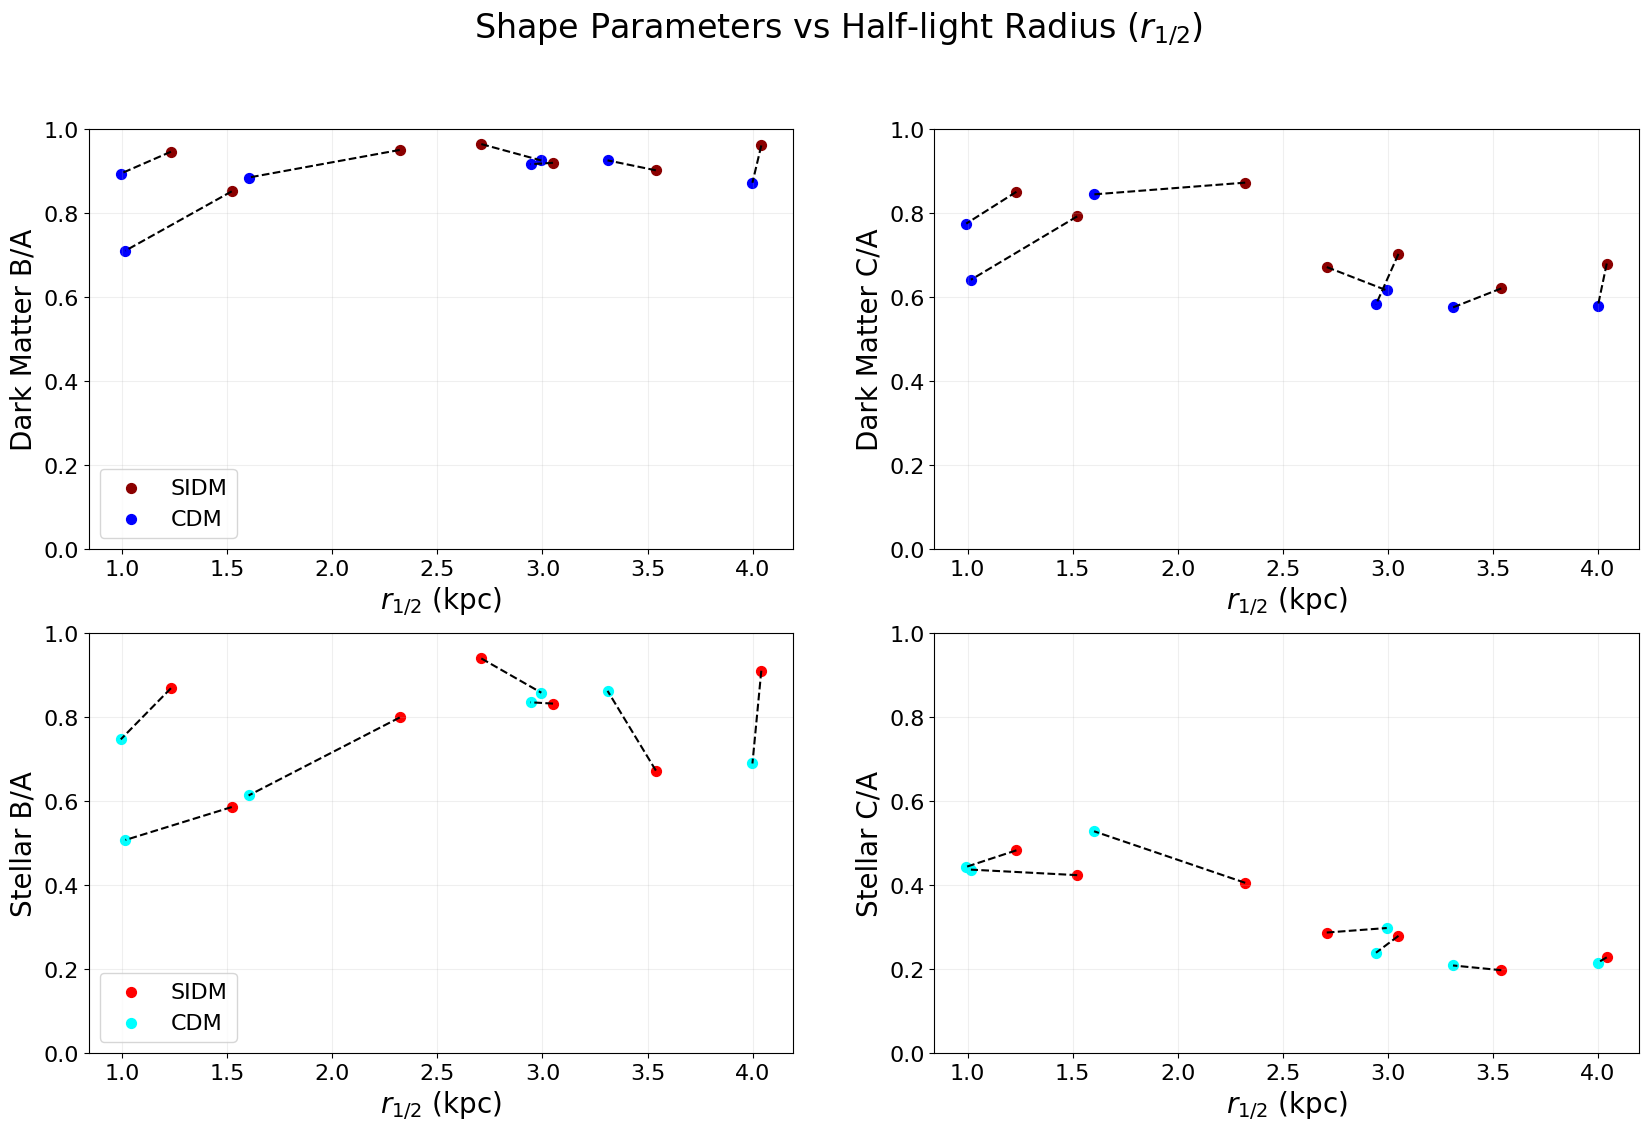

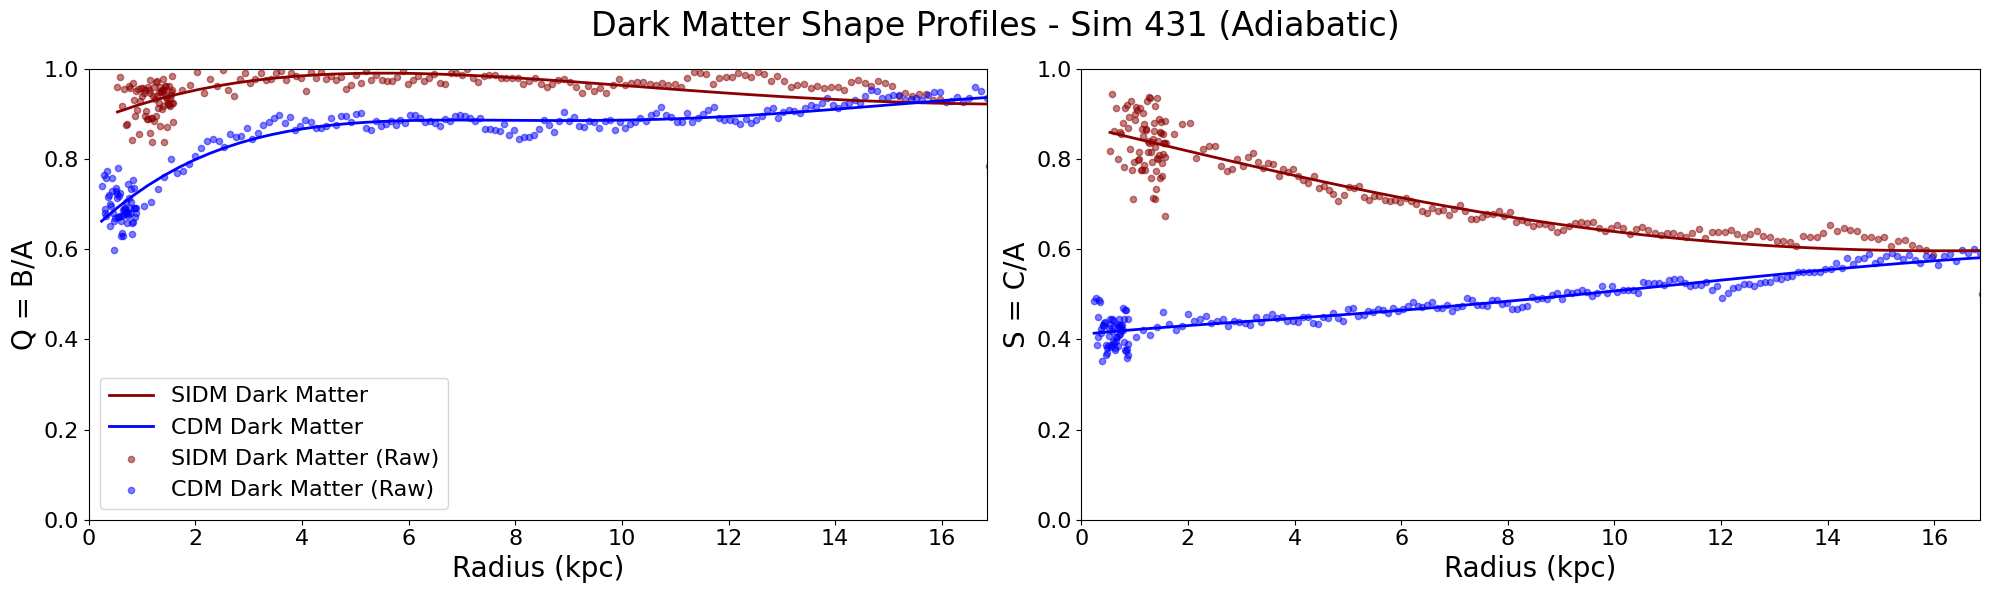

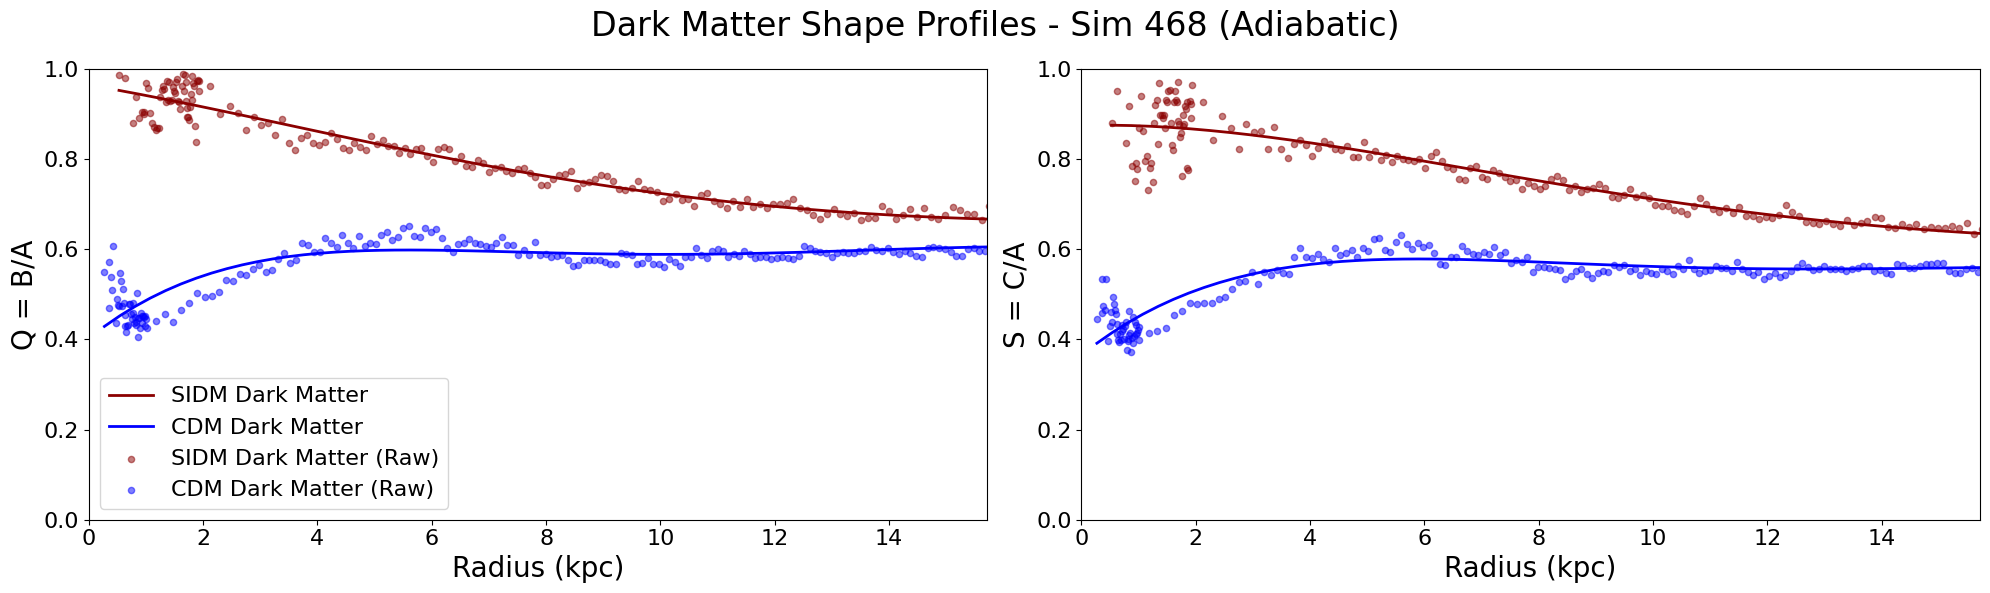

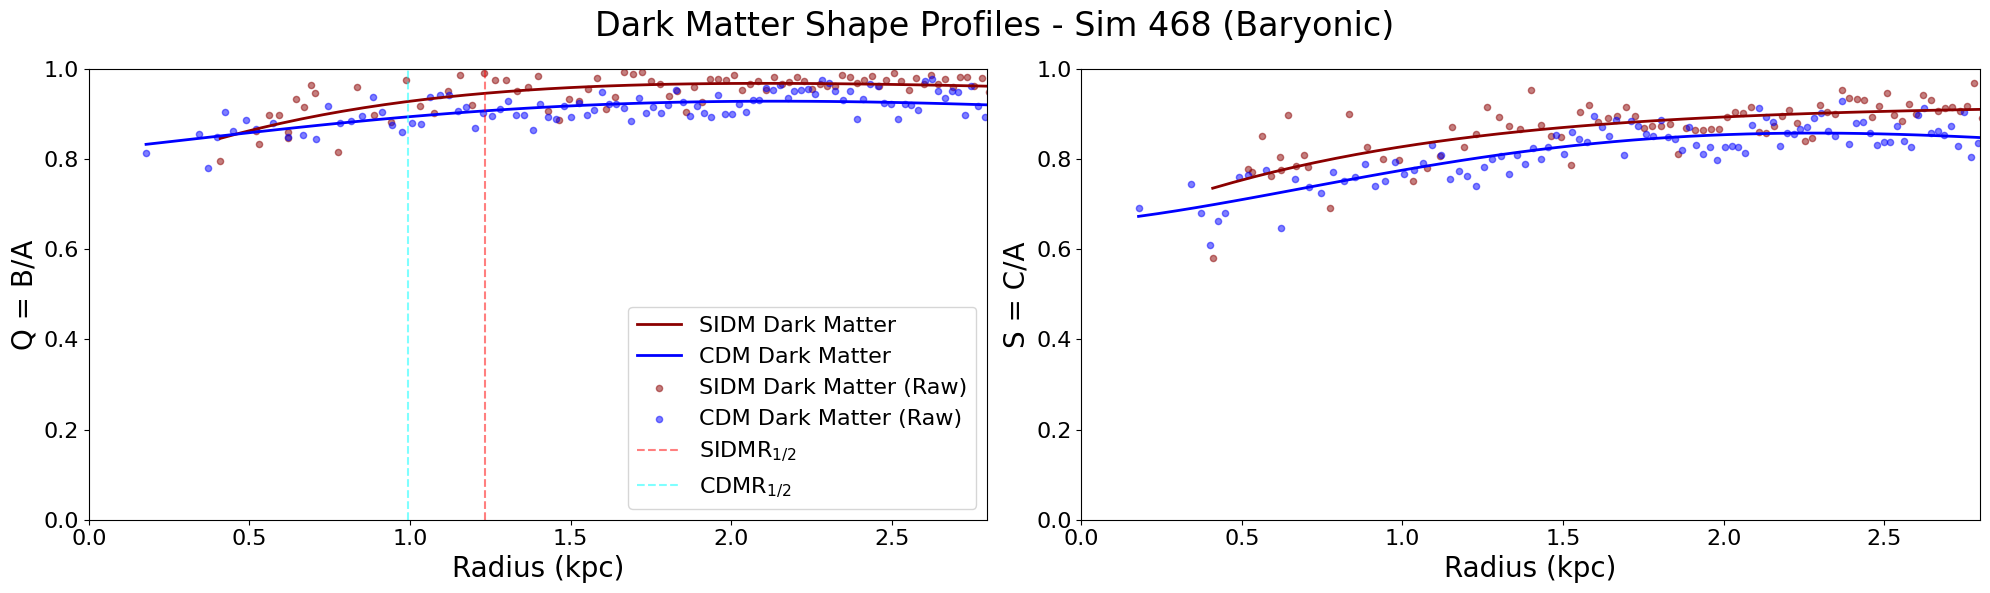

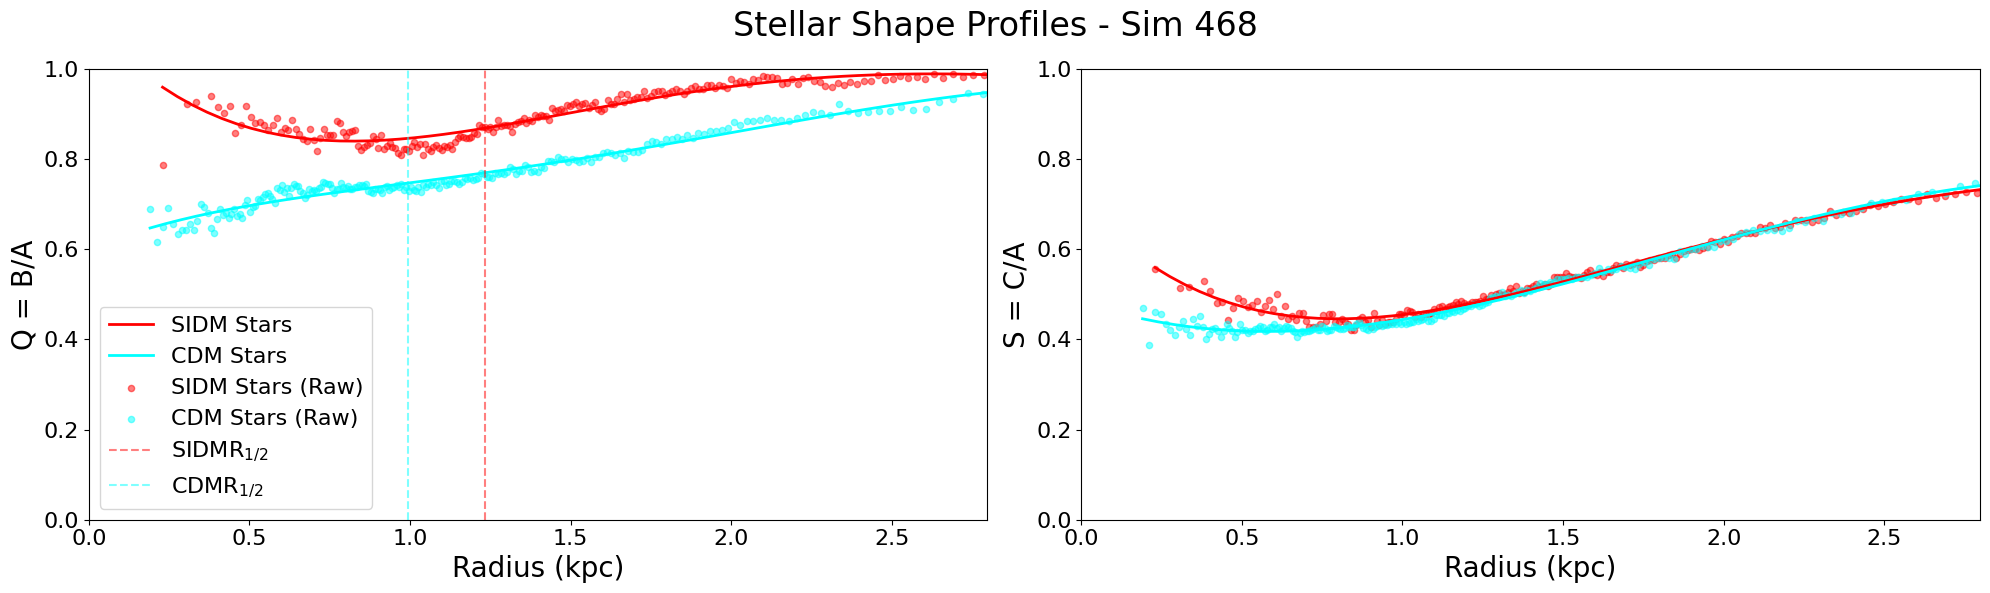

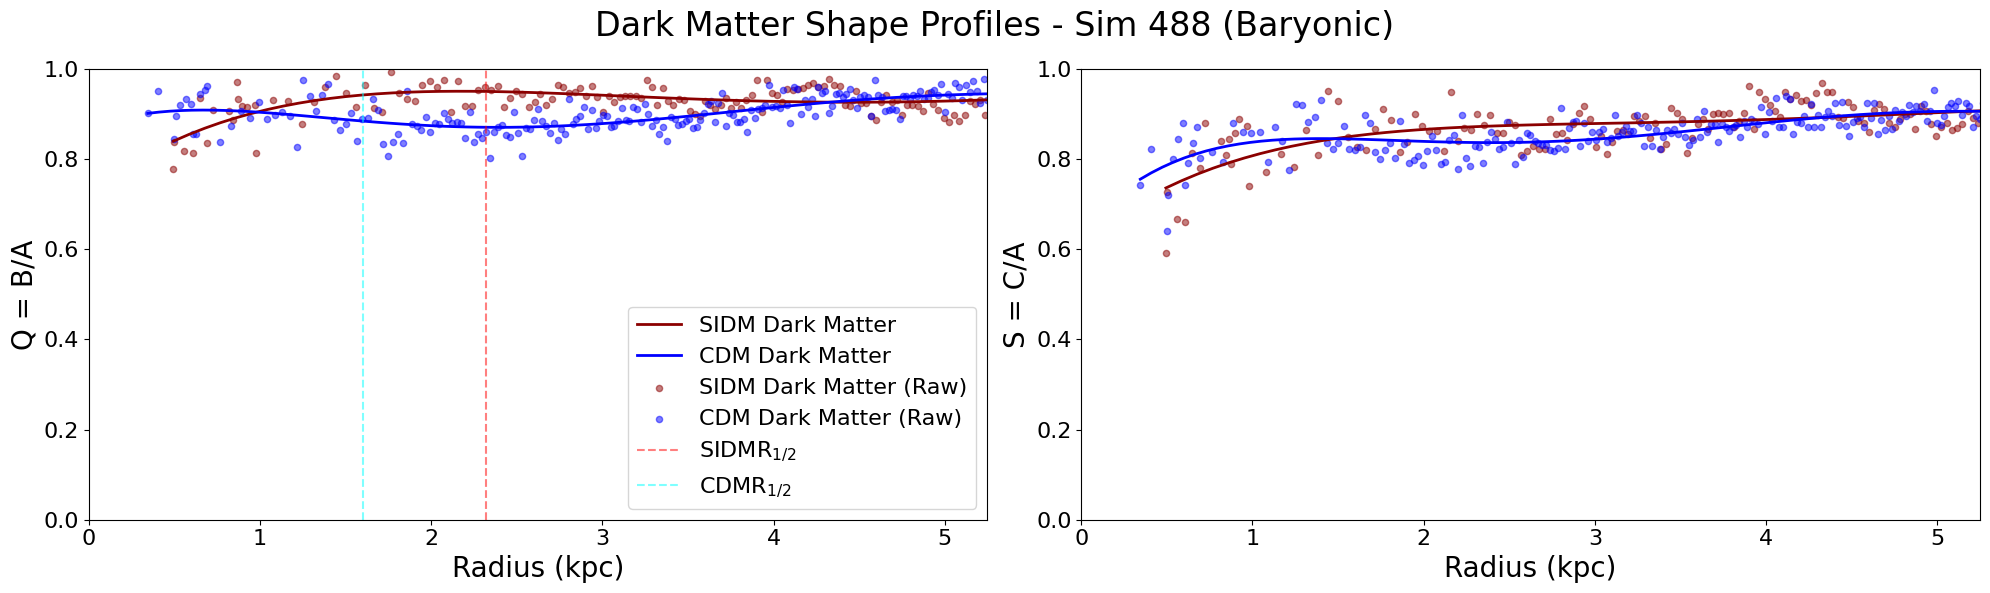

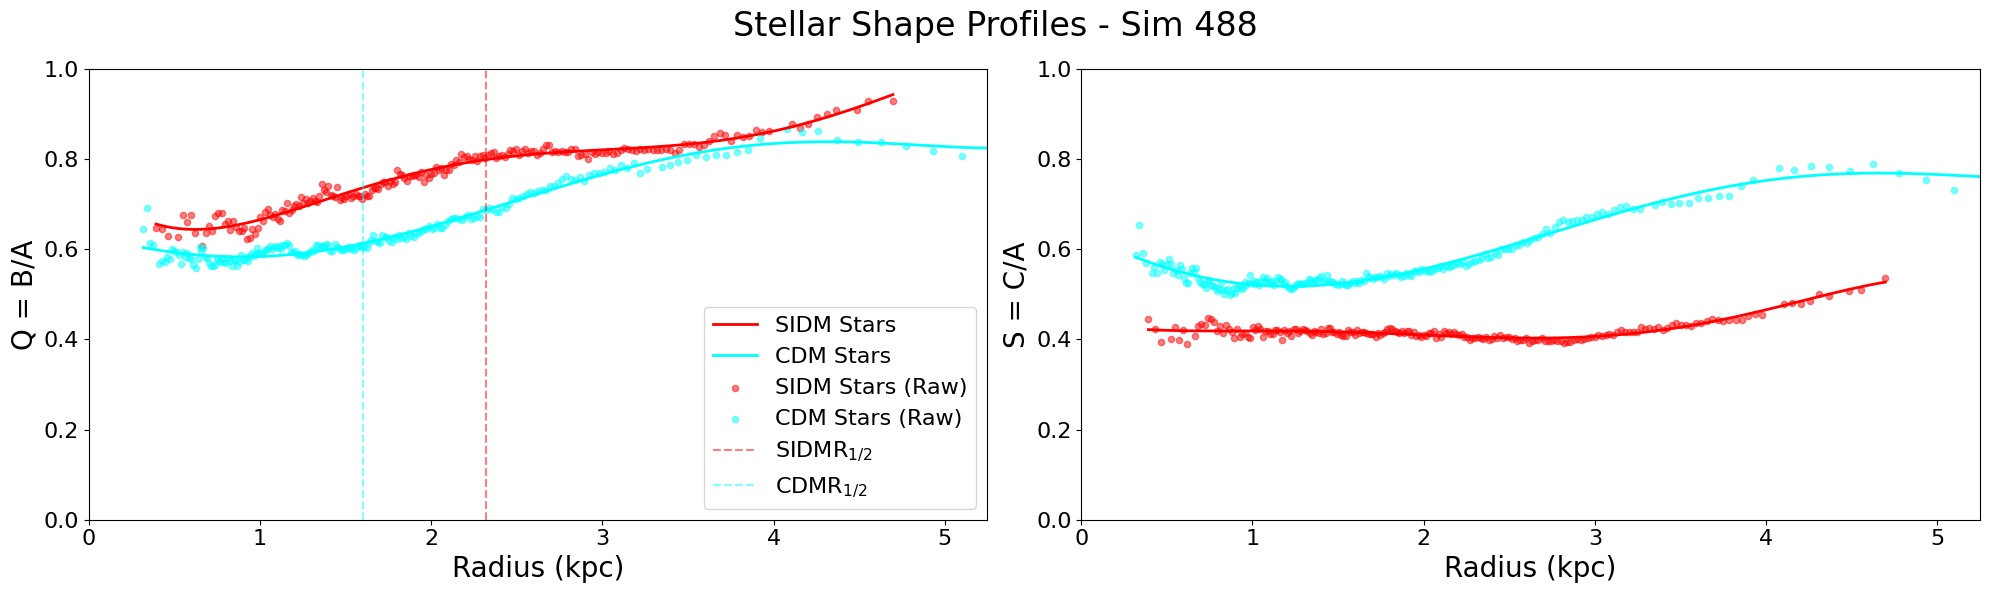

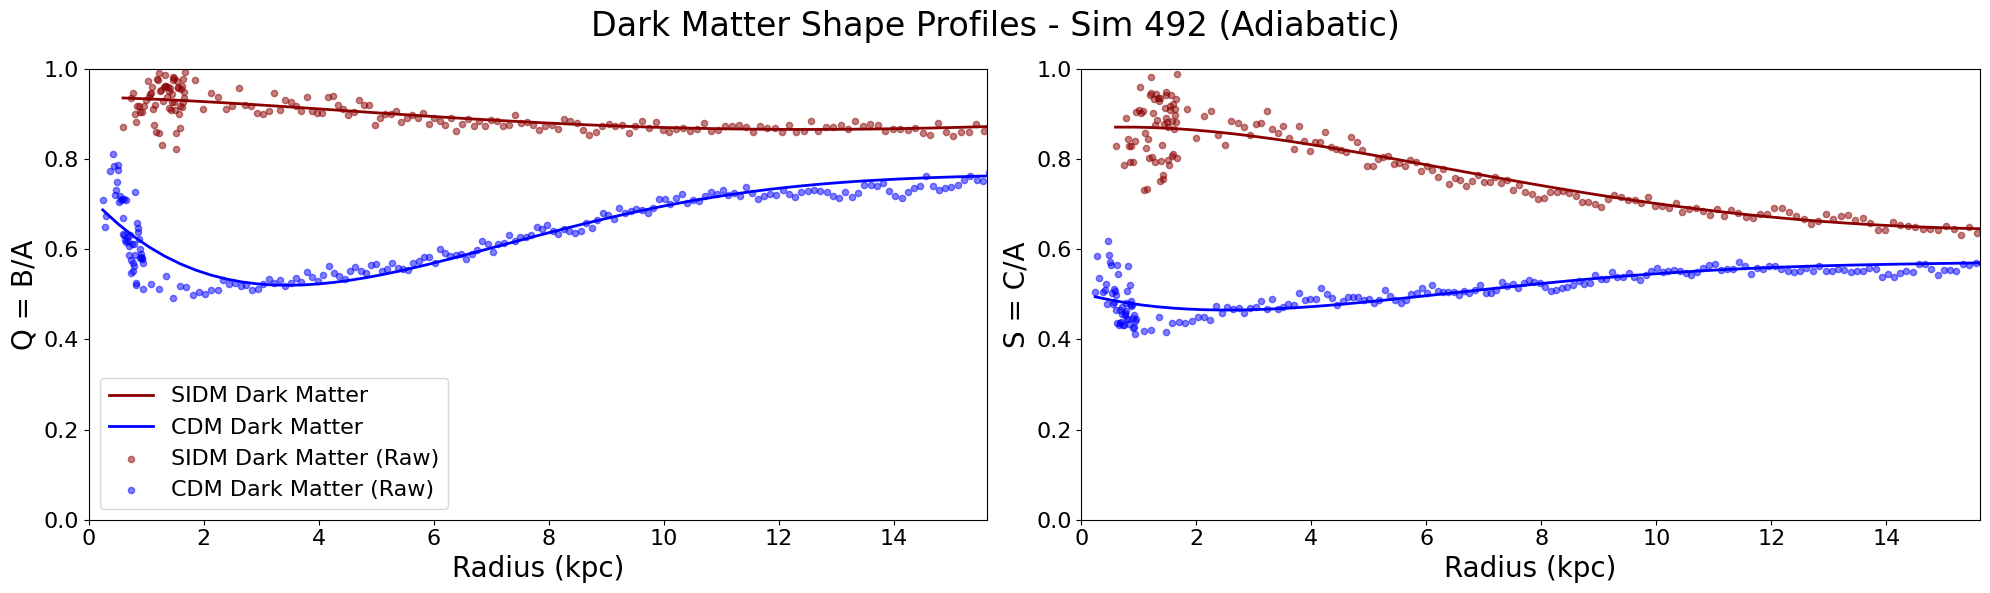

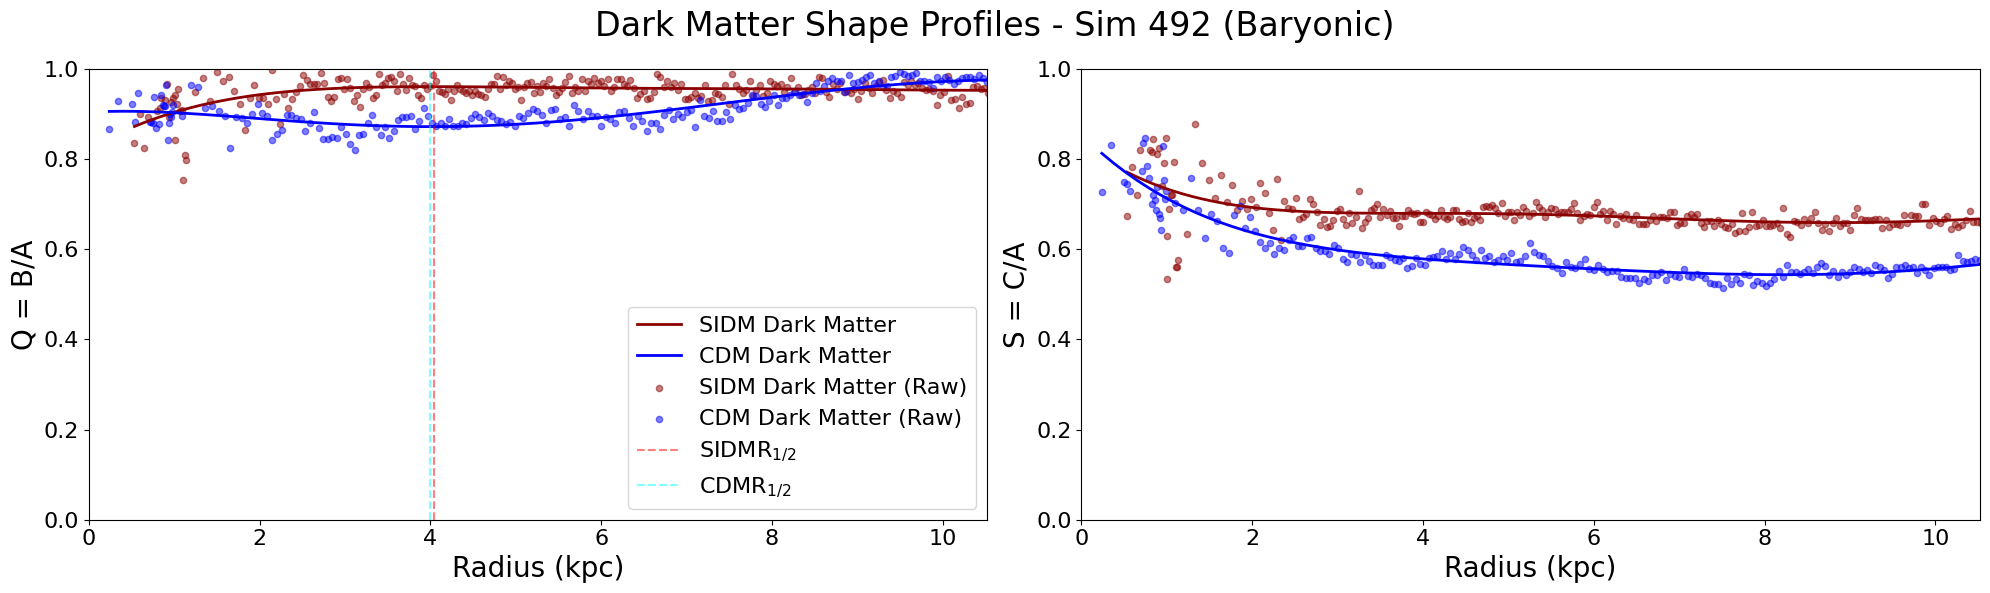

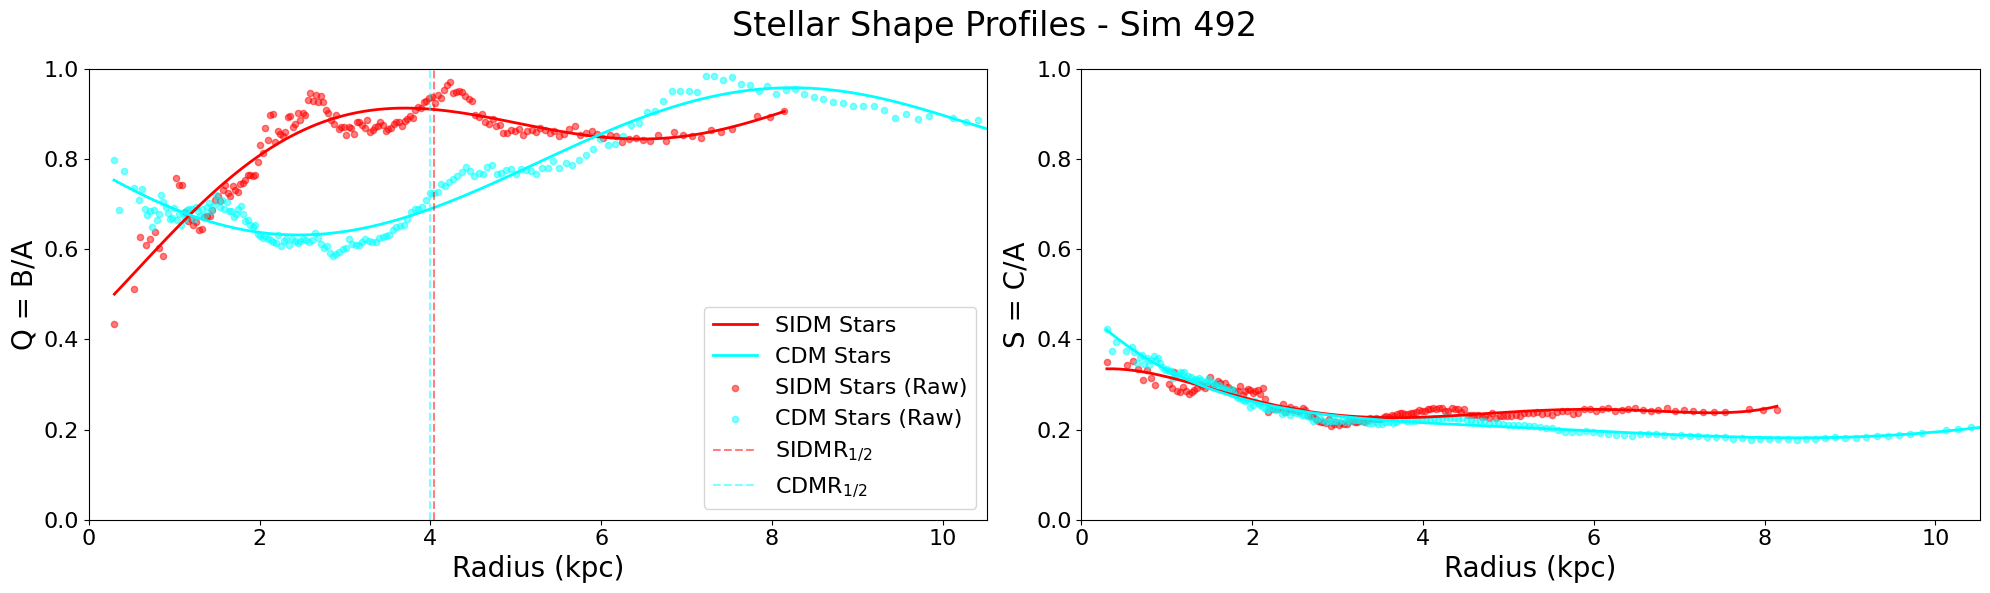

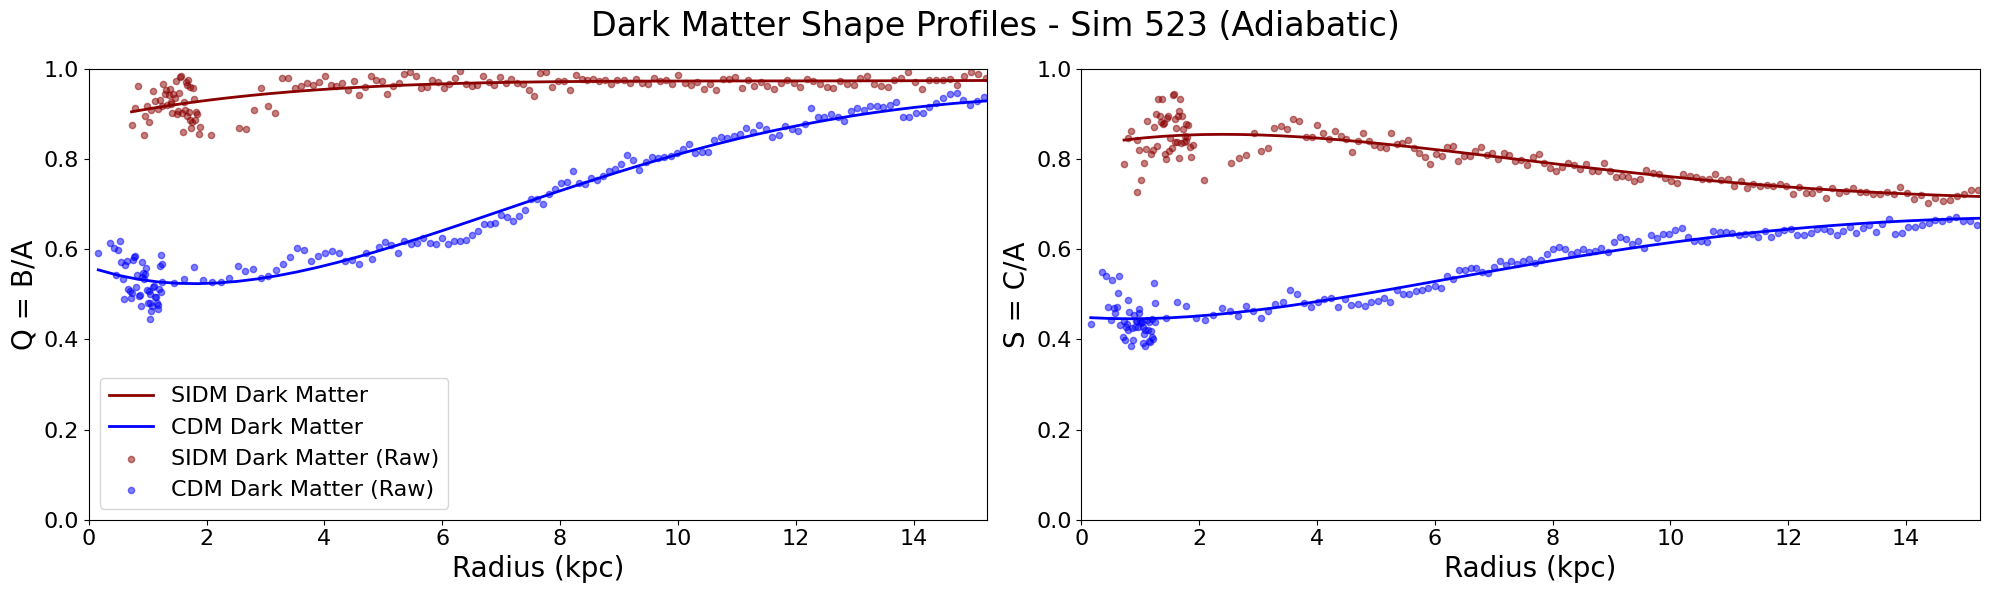

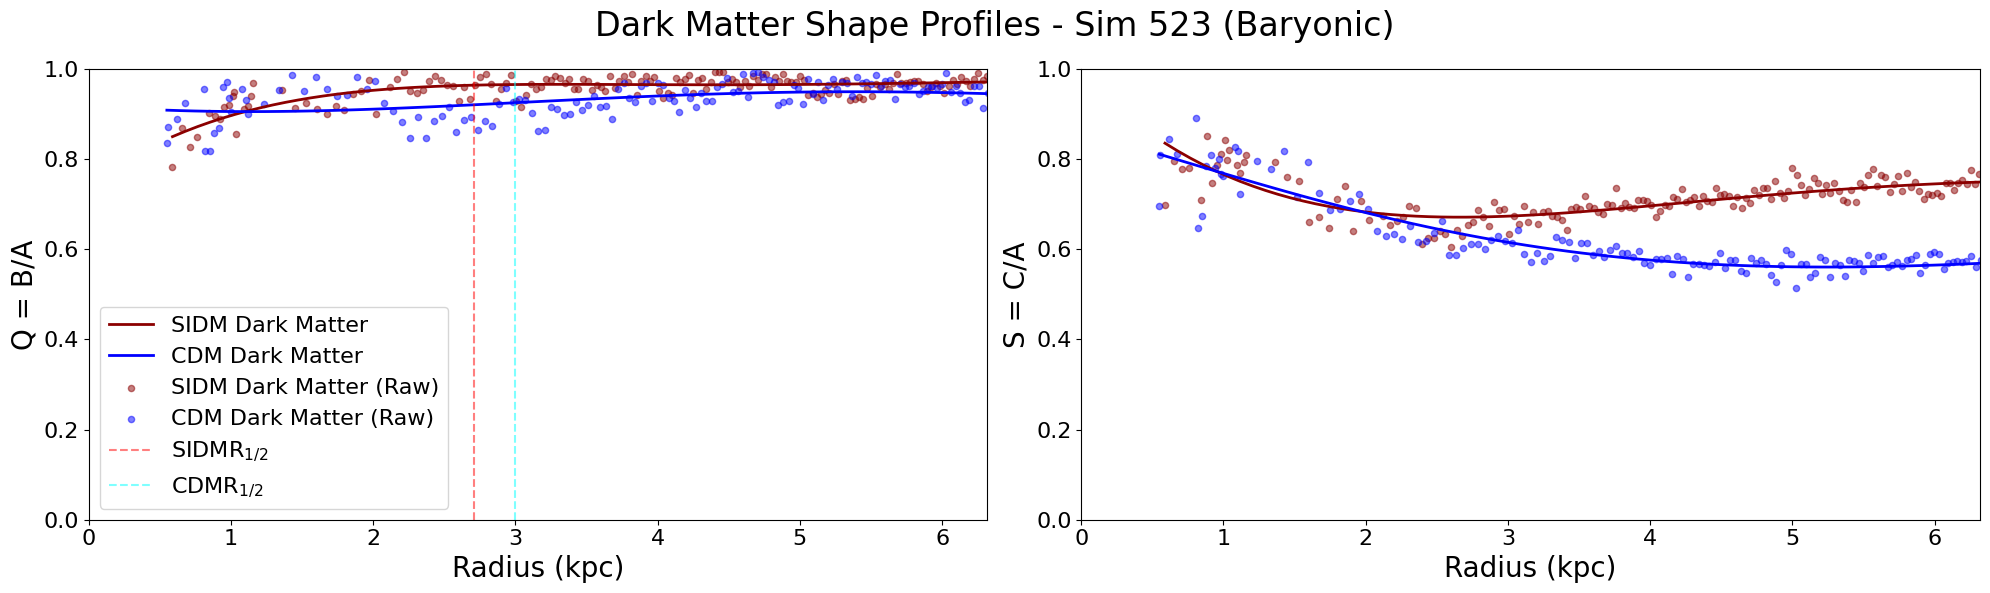

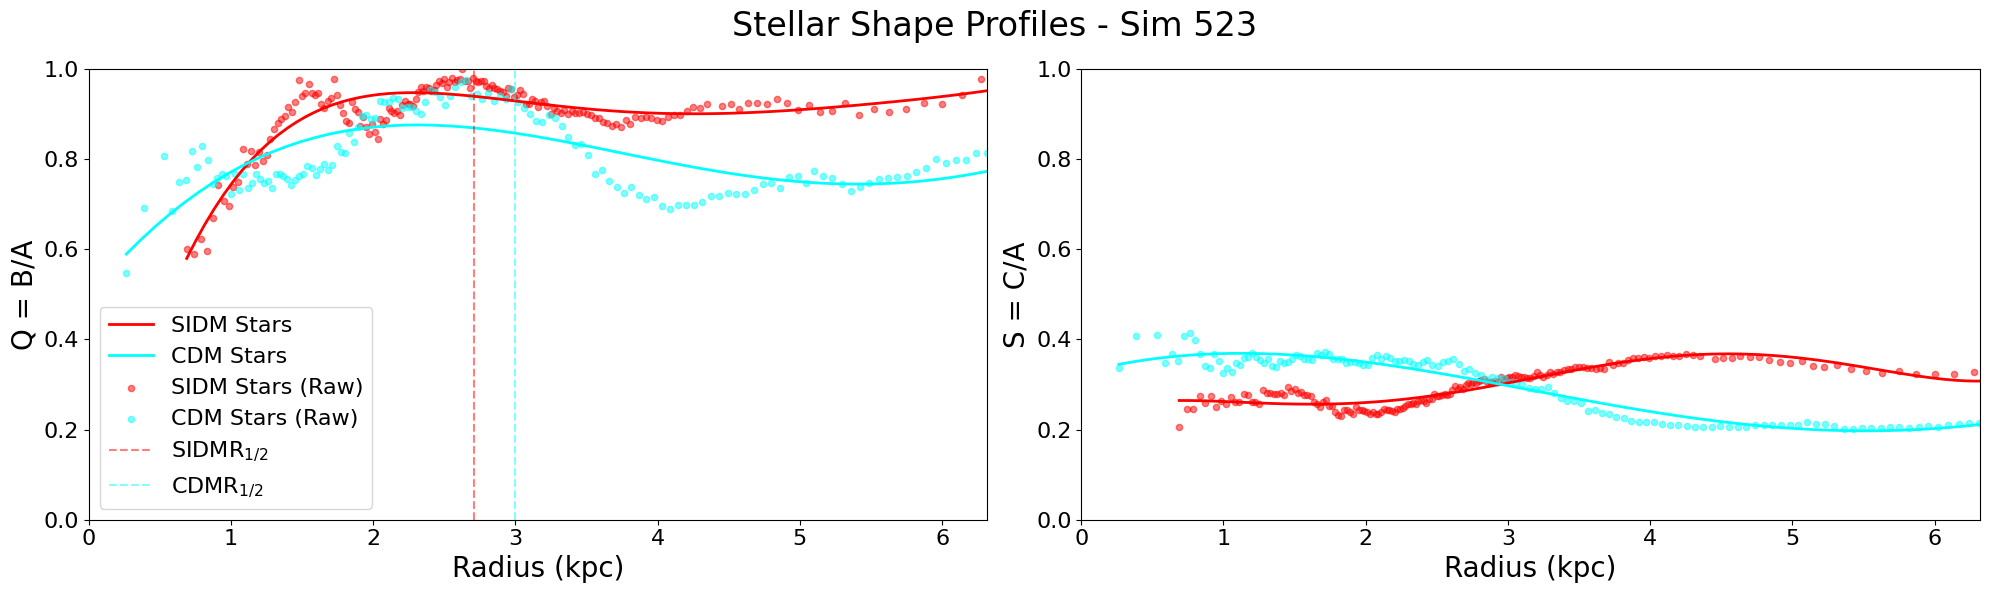

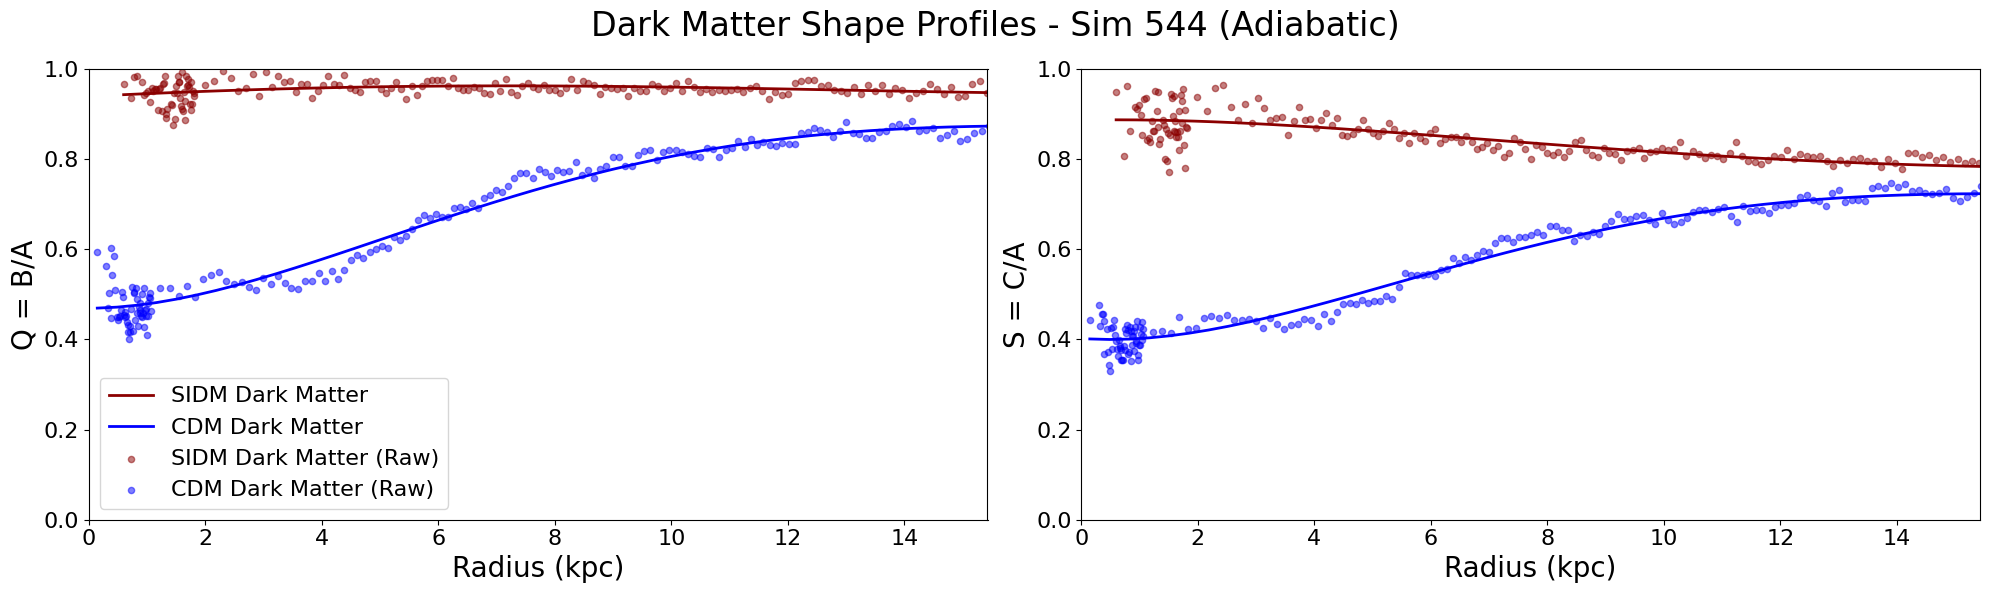

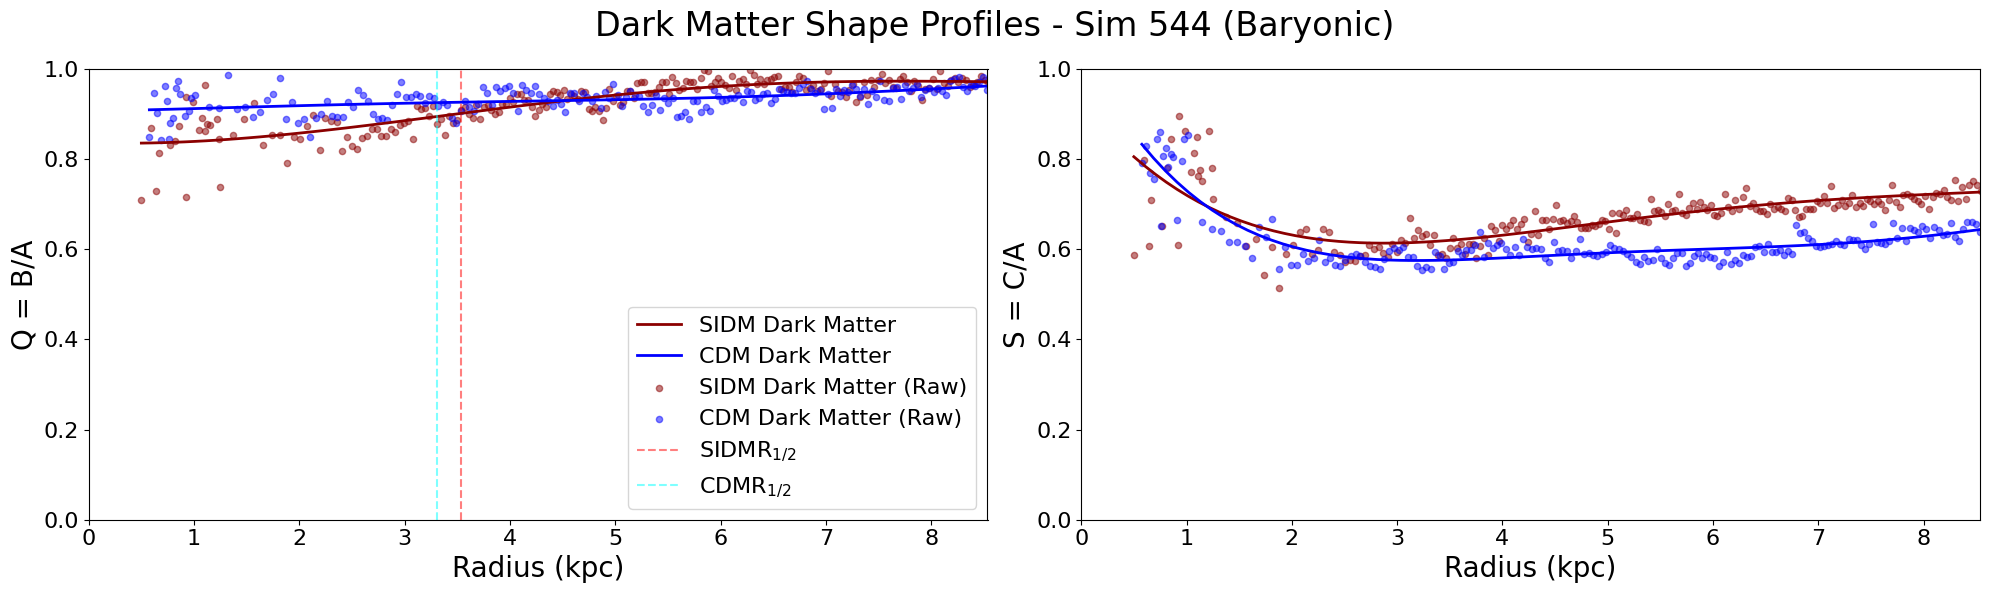

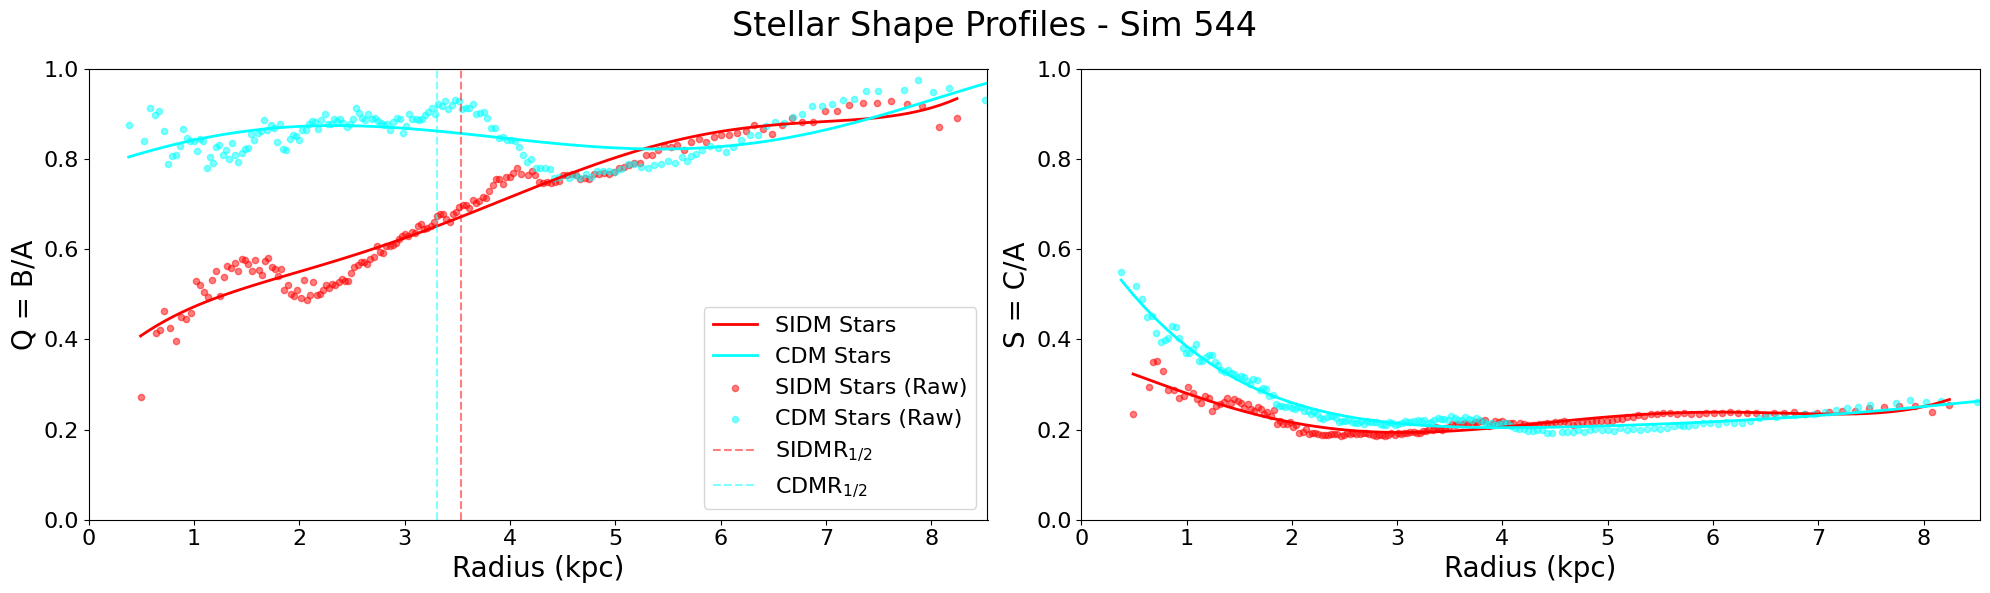

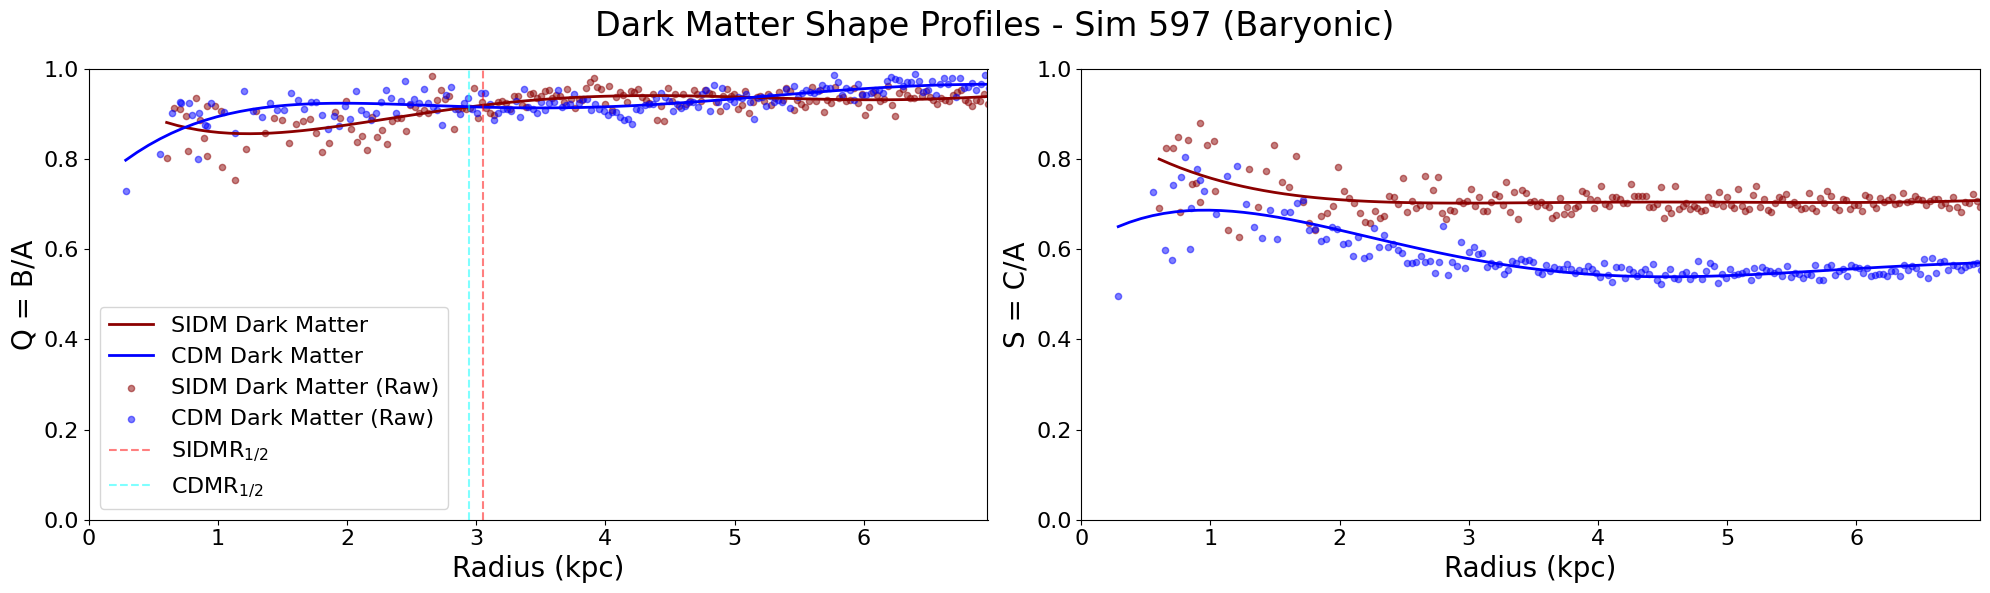

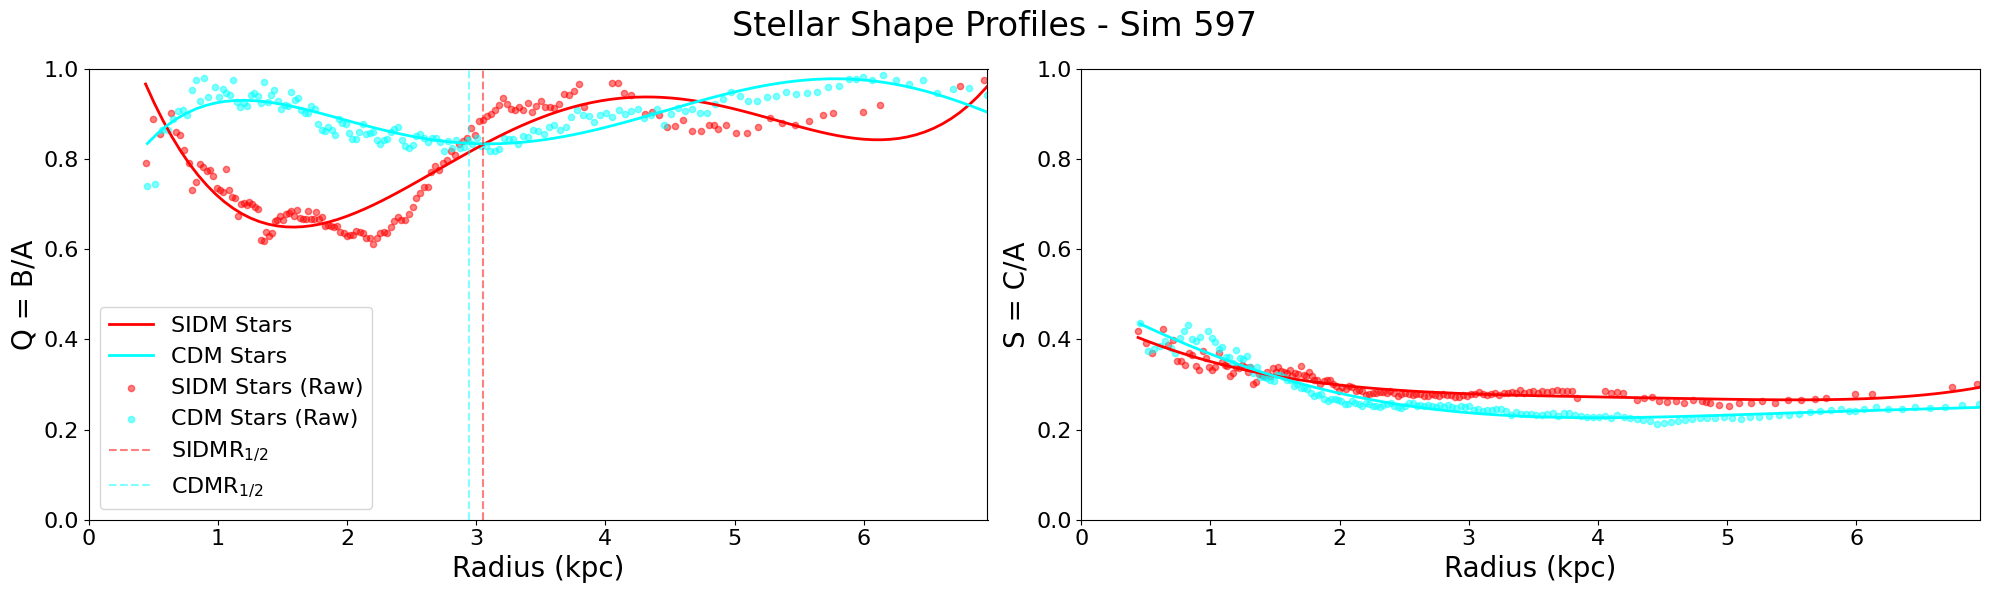

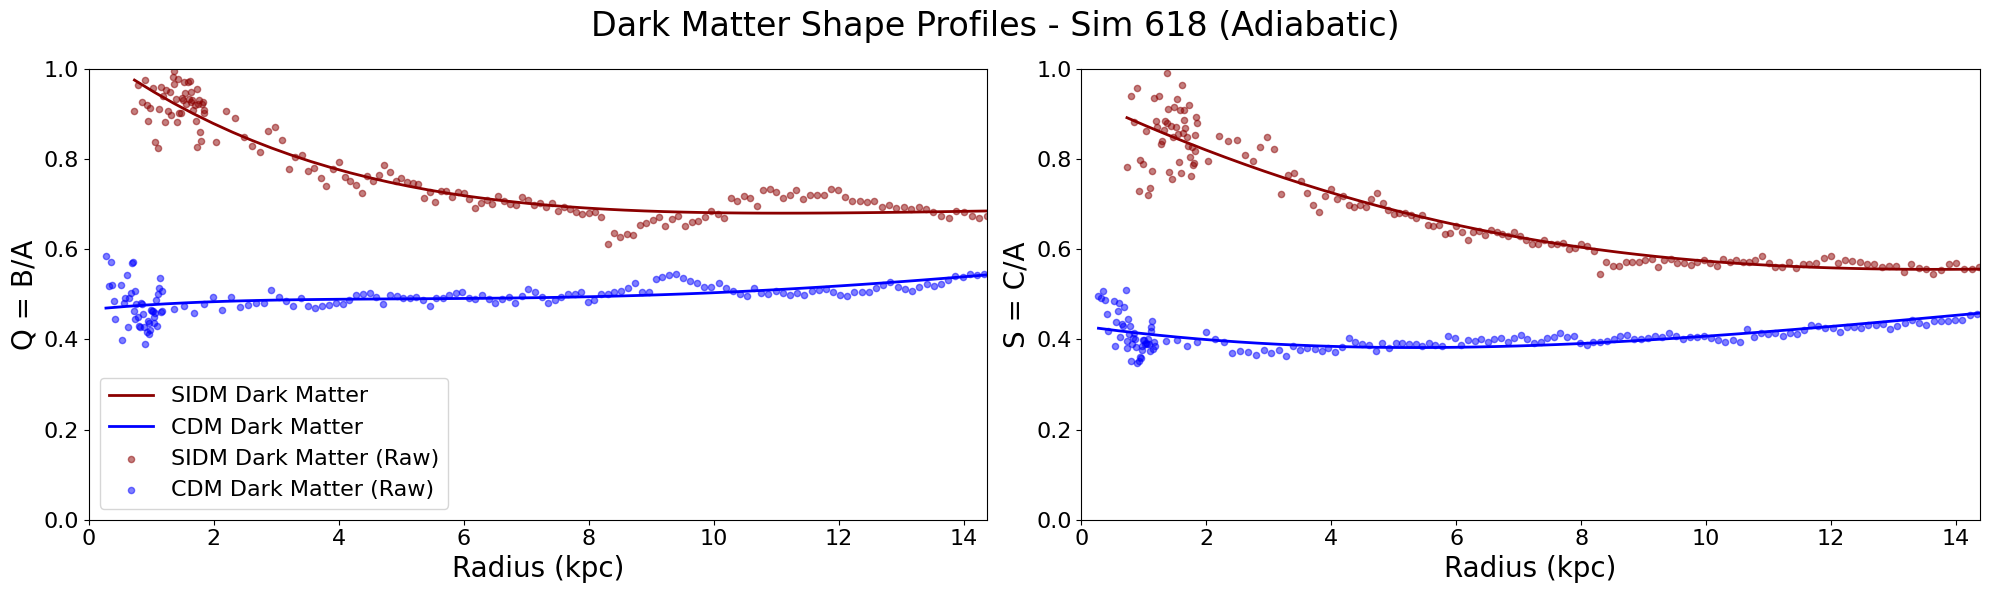

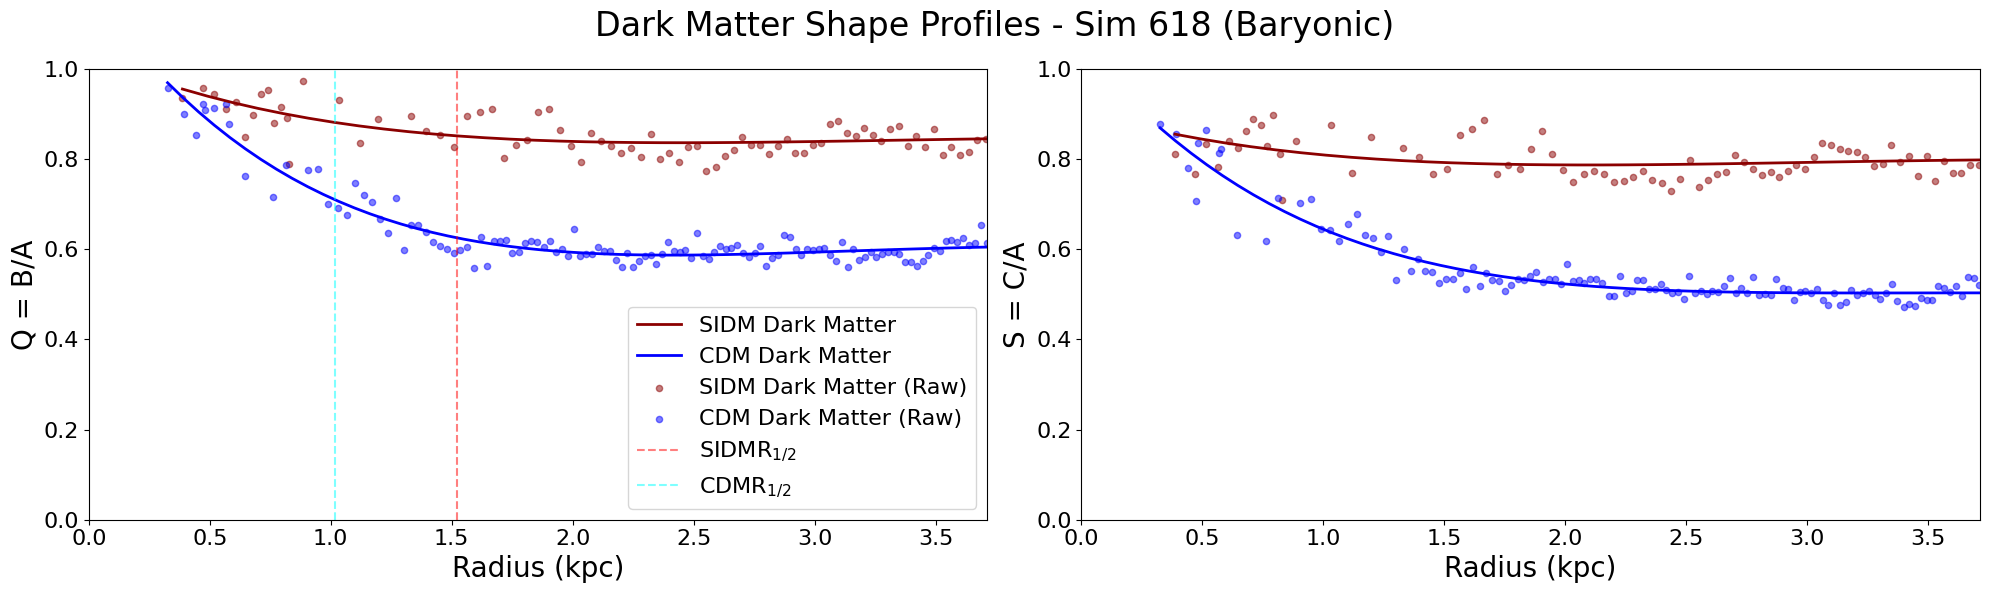

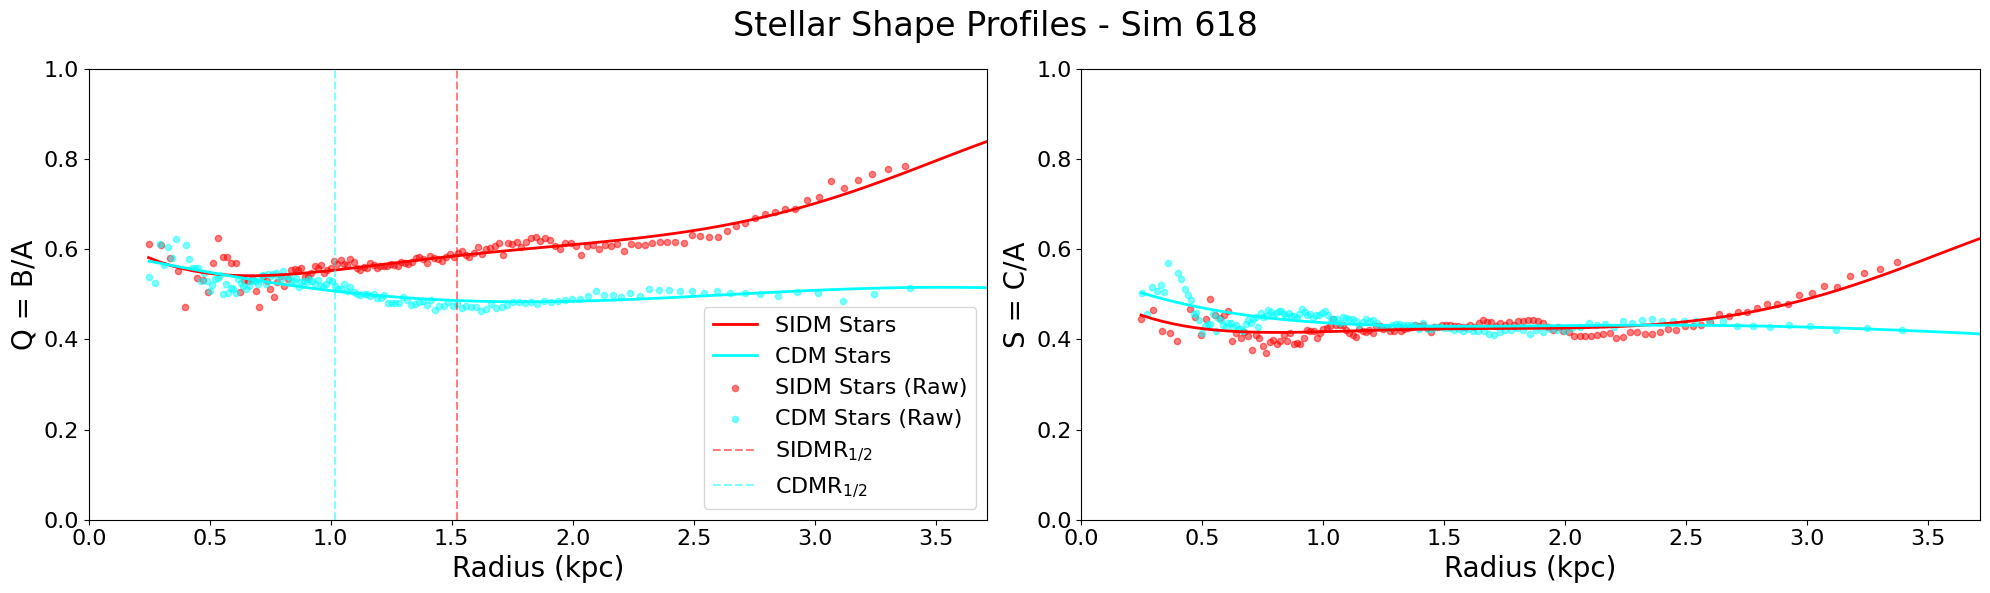

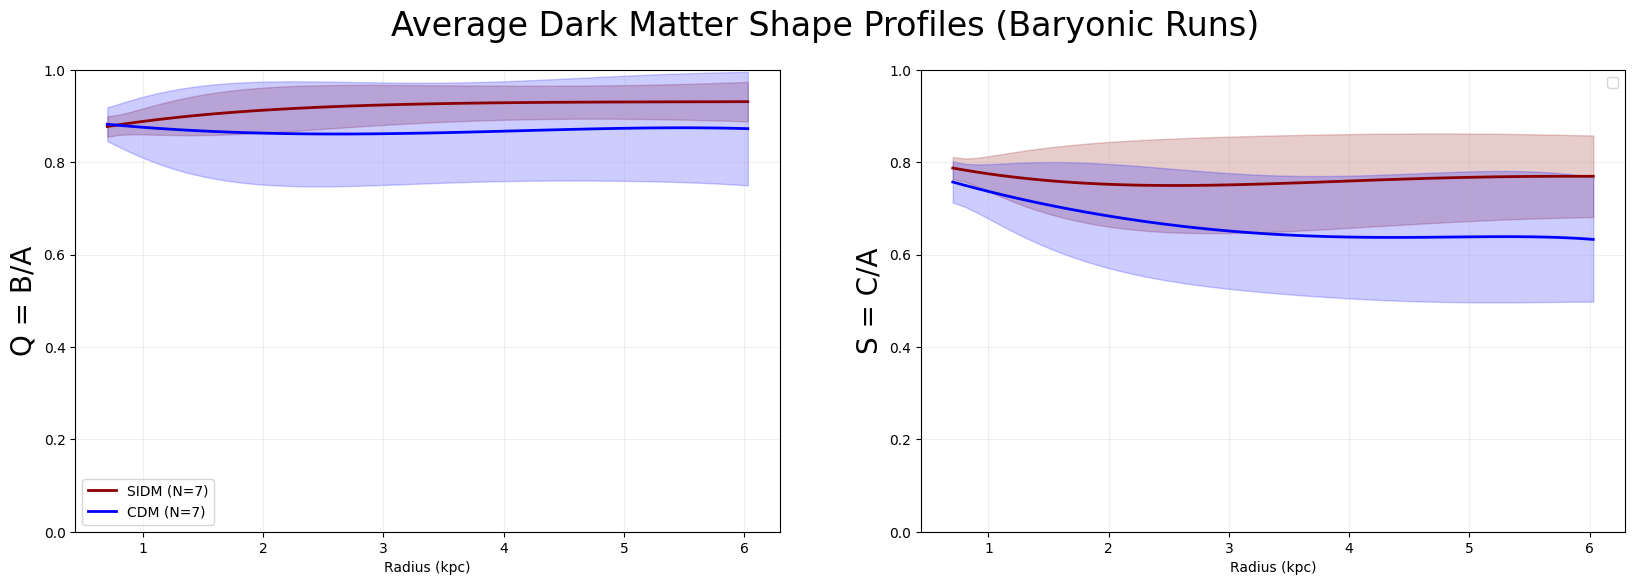

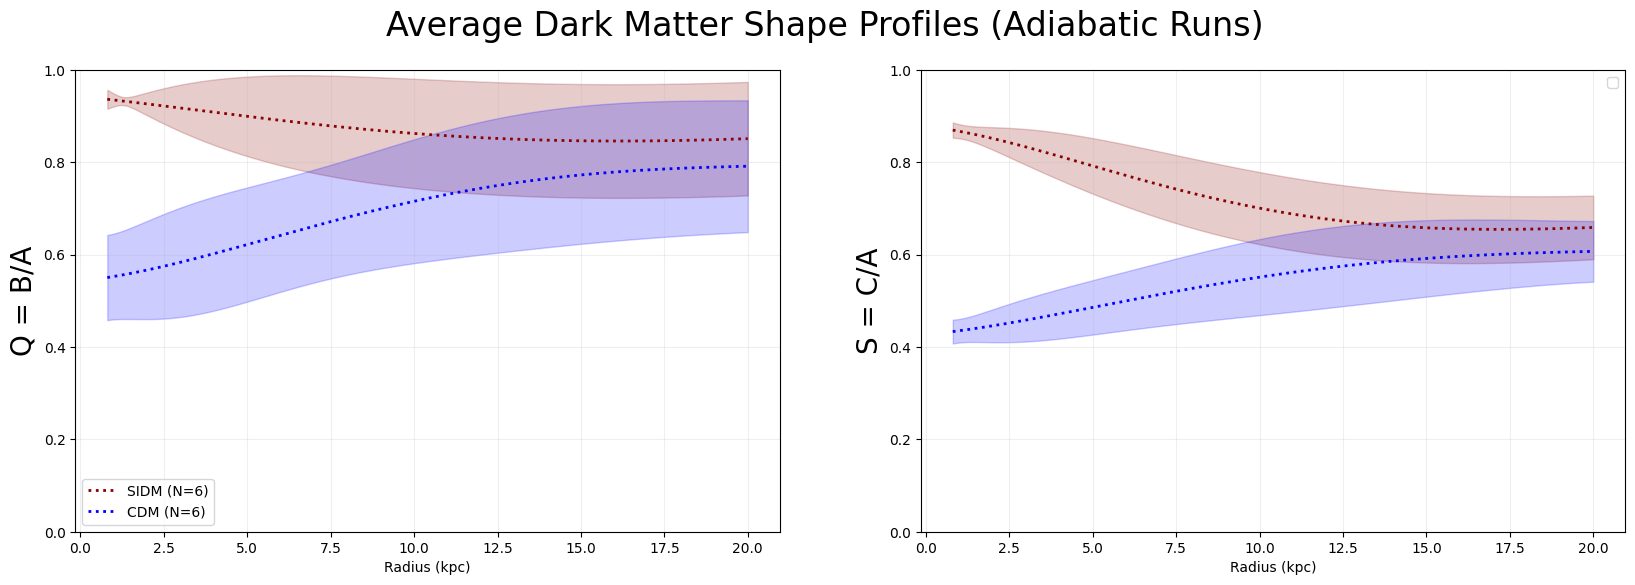

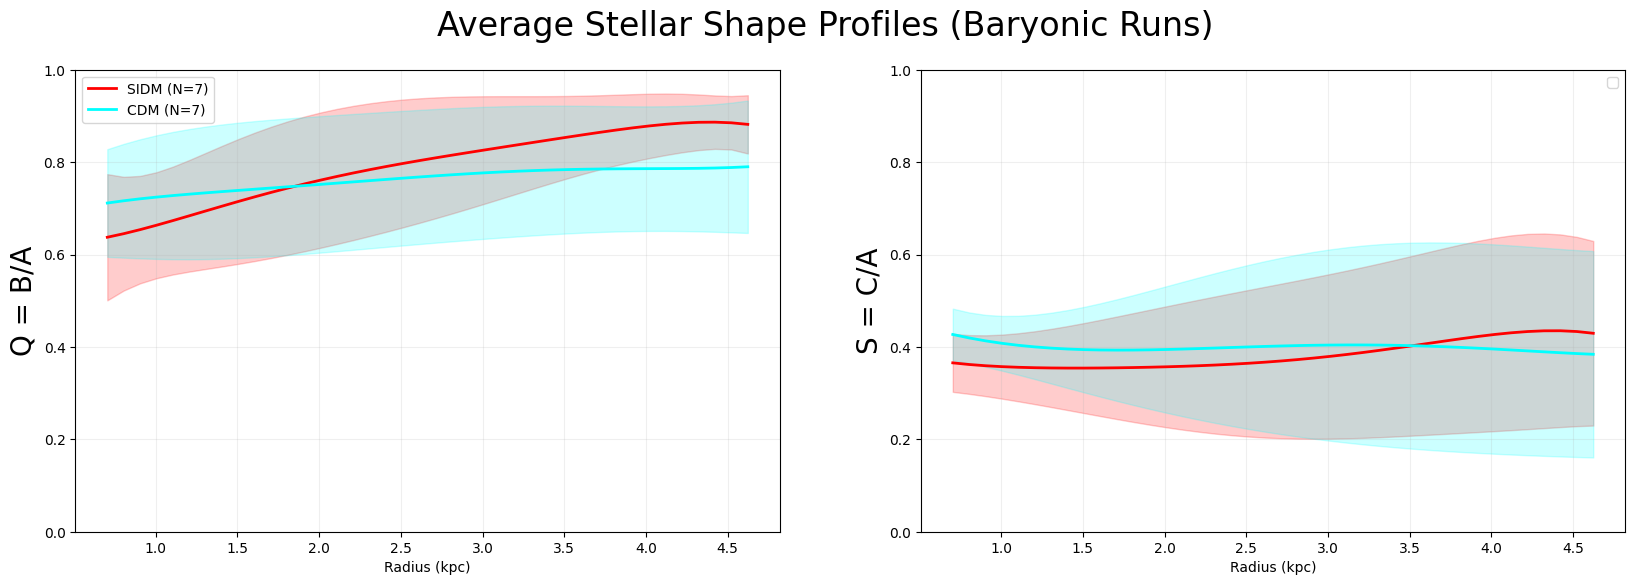

In [53]:
# Initialize the analyzer
analyzer = GalaxyShapeAnalyzer(sims, verbose=True)

# Plot shape profiles
analyzer.plot_shapes(save_path="galaxy_shapes.png")

# Plot average shape profiles
analyzer.plot_average_shapes(save_path="average_shapes")





Processing adiabatic/r431.romulus25.3072g1HsbBH
Data extracted:
- Is SIDM: False
- Is Baryonic: False

Processing adiabatic/r431.romulus25si2s50v35
Data extracted:
- Is SIDM: True
- Is Baryonic: False

Processing adiabatic/r468.romulus25.3072g1HsbBH
Data extracted:
- Is SIDM: False
- Is Baryonic: False

Processing adiabatic/r468.romulus25si2s50v35
Data extracted:
- Is SIDM: True
- Is Baryonic: False

Processing adiabatic/r488.romulus25si2s50v35
Data extracted:
- Is SIDM: True
- Is Baryonic: False

Processing adiabatic/r492.romulus25.3072g1HsbBH
Data extracted:
- Is SIDM: False
- Is Baryonic: False

Processing adiabatic/r492.romulus25si2s50v35
Data extracted:
- Is SIDM: True
- Is Baryonic: False

Processing adiabatic/r523.romulus25.3072g1HsbBH
Data extracted:
- Is SIDM: False
- Is Baryonic: False

Processing adiabatic/r523.romulus25si2s50v35
Data extracted:
- Is SIDM: True
- Is Baryonic: False

Processing adiabatic/r544.romulus25.3072g1HsbBH
Data extracted:
- Is SIDM: False
- Is Baryon

/tmp/ipykernel_2838110/3722142014.py:174: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


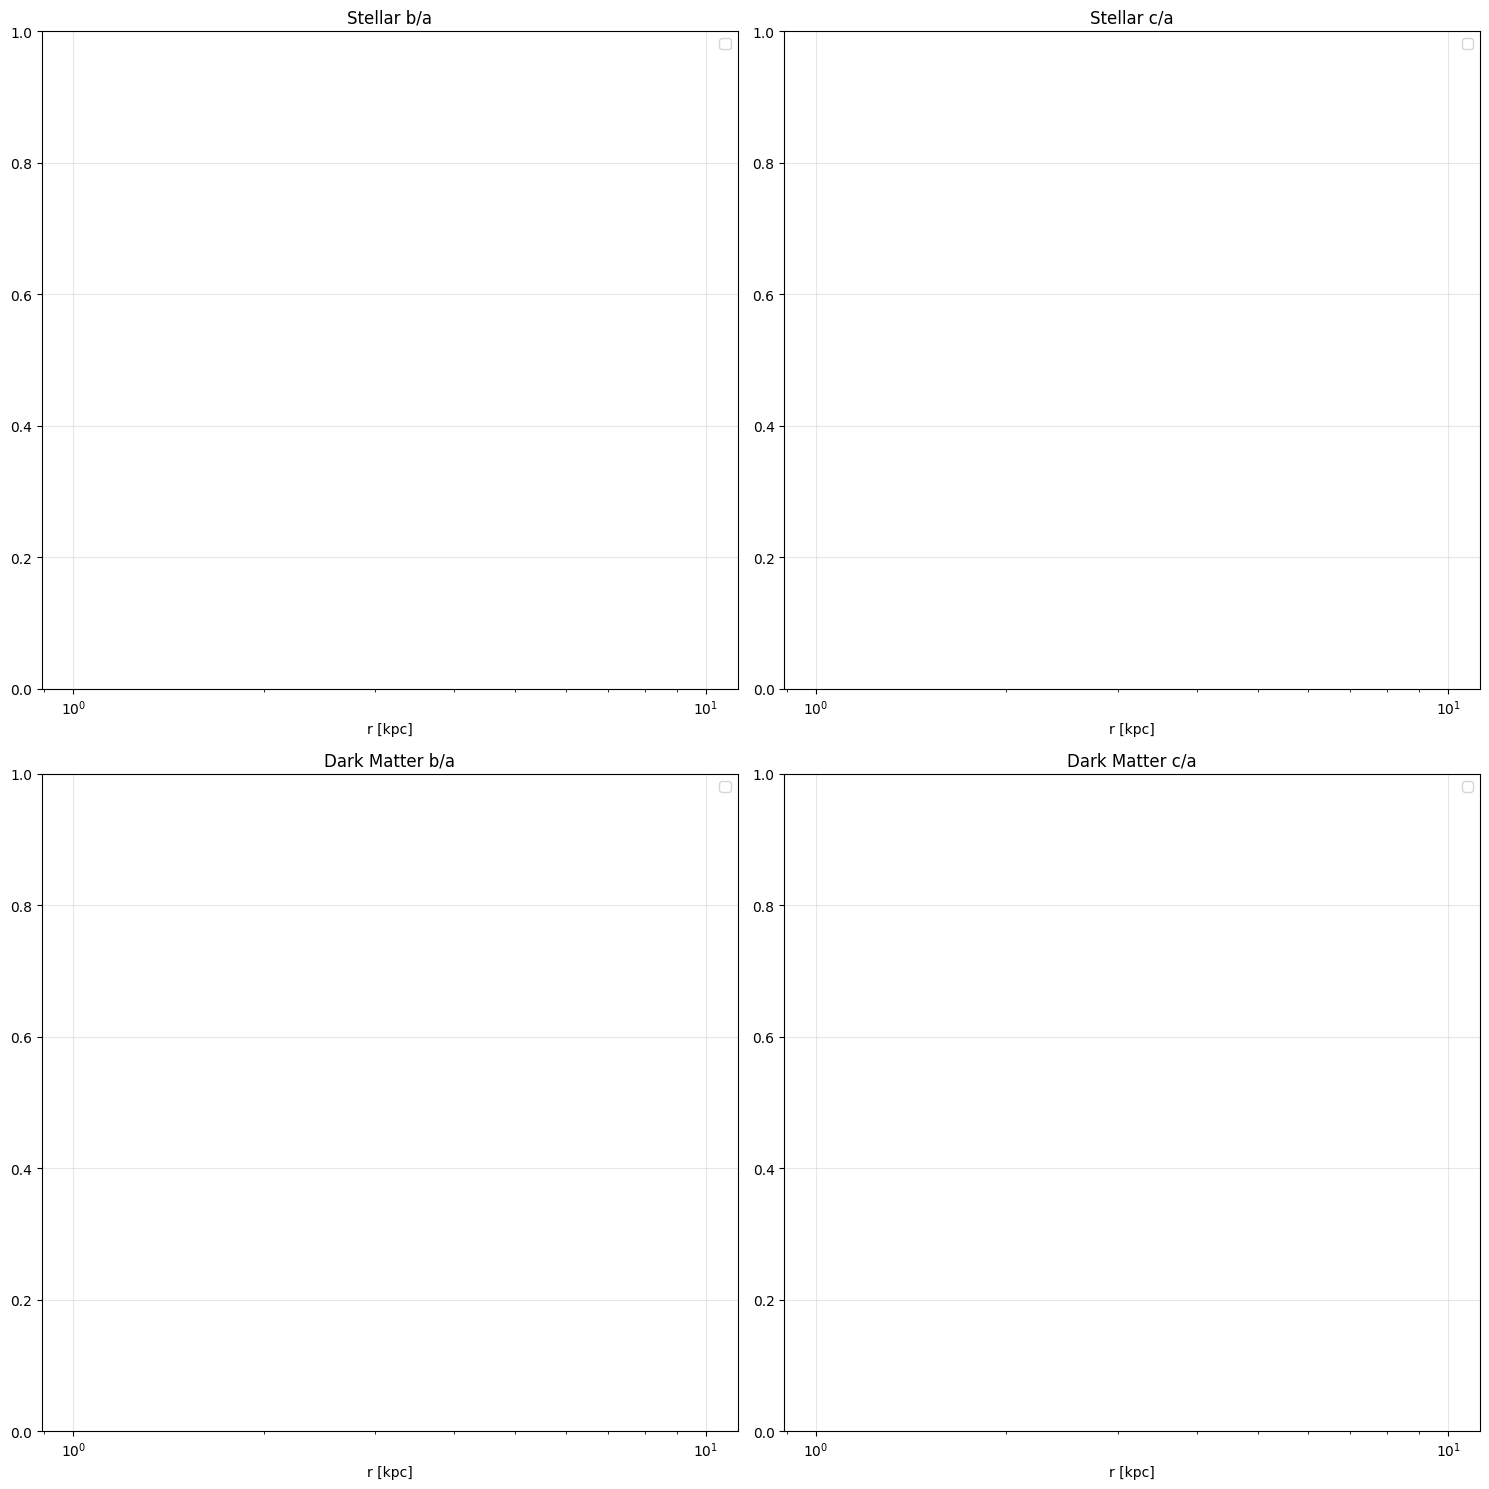

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

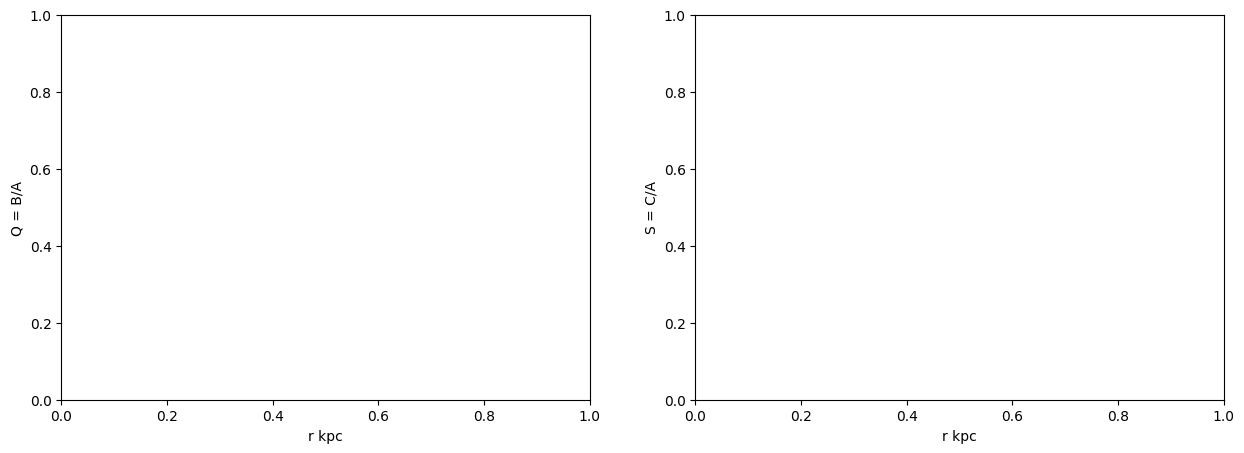

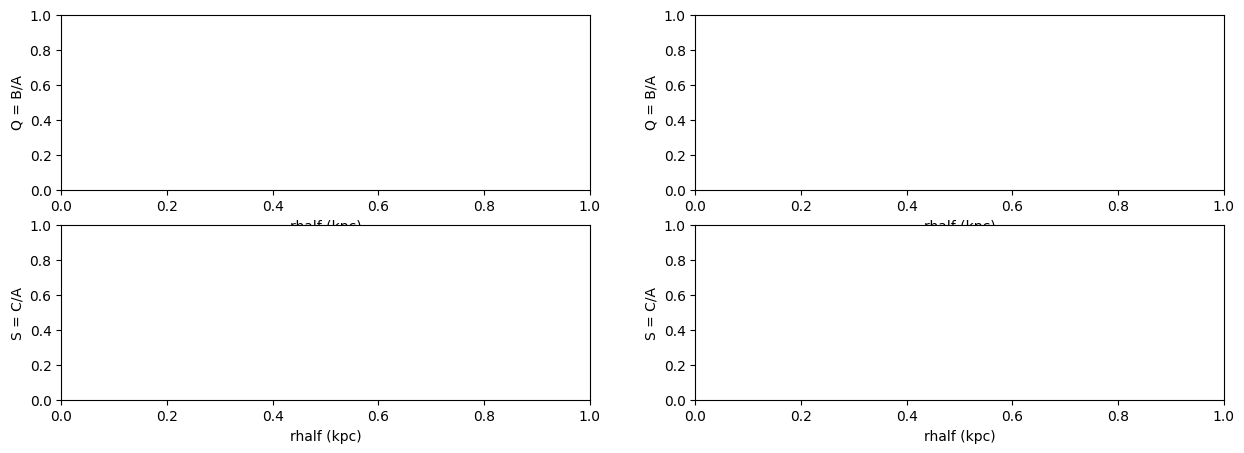

In [10]:
# Initialize the analyzer
analyzer = GalaxyShapeAnalyzer()

# Add simulations
for sim in sims:
    sim_name = sim.basename
    print(f"\nProcessing {sim_name}")

    # Add debug prints in the processing step
    try:
        sim_data = analyzer.process_simulation(sim, sim_name)
        print("Data extracted:")
        print(f"- Is SIDM: {sim_data.is_sidm}")
        print(f"- Is Baryonic: {sim_data.is_baryonic}")
        analyzer.add_simulation(sim, sim_name)
    except Exception as e:
        print(f"Error processing {sim_name}: {str(e)}")

# Print matching pairs
print("\nMatching pairs found:")
pairs = analyzer.get_matching_pairs()
for sidm_name, cdm_name in pairs:
    print(f"SIDM: {sidm_name} <-> CDM: {cdm_name}")

# Generate plots
analyzer.plot_shape_profiles(save_path="galaxy_shapes.png")

# Get summary statistics
stats = analyzer.get_summary_statistics()
print("\nSummary Statistics:")
print(stats)